# Anomaly Detection Pipeline – Converted from main.py

In [ ]:
import os
import pandas as pd
import time
from datetime import datetime
from collections import defaultdict, deque
import paho.mqtt.client as mqtt
from config import DEVICES_DATA_PATH, SAVED_MODELS_PATH, global_start_time, process, start_memory
from device_utils import get_device_files, get_model_name, get_numerical_features
from state_anomaly import detect_state_anomalies
from rf_classifier import apply_random_forest, train_rf_for_device
from plotting import plot_lstm_vs_rf, plot_reconstruction_error
import MQTT_receiver as mqtt_receiver


In [ ]:
def process_device_offline(device_type, csv_file):
    """
    Process a device's data and apply anomaly detection and classification.
    """
    print(f"\n{'=' * 50}")
    print(f"Processing device: {device_type}")
    print(f"{'=' * 50}\n")

    device_start_time = pd.Timestamp.now()
    df_all = pd.DataFrame()
    print(csv_file, device_type)

    try:
        df = pd.read_csv(os.path.join(DEVICES_DATA_PATH, csv_file))
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        available_features = get_numerical_features(df)

        if not available_features:
            print(f"⚠️ {device_type} - No numeric features detected.")
            return None

        print(f"{device_type} - Auto-detected features: {available_features}")

        for state in df['state'].unique():
            model_name = get_model_name(device_type, state)
            model_path = os.path.join(SAVED_MODELS_PATH, model_name)

            if not os.path.exists(model_path):
                print(f"⚠️ Missing model for {device_type} state: {state}")
                continue

            df_state = df[df['state'] == state].copy()
            df_processed = detect_state_anomalies(df_state, model_path, available_features)

            if 'reconstruction_error' in df_processed.columns:
                df_all = pd.concat([df_all, df_processed])
                plot_reconstruction_error(df_processed, device_type, state)

        if df_all.empty:
            return None

        df_all.sort_values('timestamp', inplace=True)
        df_all.reset_index(drop=True, inplace=True)

        df_all = apply_random_forest(df_all, device_type)
        plot_lstm_vs_rf(df_all, device_type)

        print(f"✅ Finished {device_type} in {(pd.Timestamp.now() - device_start_time).total_seconds():.2f} sec")
        return df_all

    except Exception as e:
        print(f"❌ Error processing {device_type}: {str(e)}")
        return df_all
    

def process_device_mqtt(device_type, df_input):
    """
    Process a device's real-time or buffered data from MQTT and apply
    anomaly detection and classification, similar to the offline pipeline.

    Args:
        device_type (str): The device name (e.g., "motor_monitor")
        df_input (Iterable[pd.DataFrame] or pd.DataFrame): MQTT-fed rows

    Returns:
        pd.DataFrame: Fully processed DataFrame (if any rows)
    """
    print(f"\n{'=' * 50}")
    print(f"Processing MQTT data for device: {device_type}")
    print(f"{'=' * 50}\n")

    device_start_time = pd.Timestamp.now()
    df_all = pd.DataFrame()

    try:
        # Support deque (list of single-row DataFrames) or a single DataFrame
        if isinstance(df_input, (list, deque)):
            df = pd.concat(df_input, ignore_index=True)
        elif isinstance(df_input, pd.DataFrame):
            df = df_input.copy()
        else:
            raise ValueError("Invalid input type. Expected DataFrame or list of DataFrames.")

        df['timestamp'] = pd.to_datetime(df['timestamp'])
        available_features = get_numerical_features(df)

        if not available_features:
            print(f"⚠️ {device_type} - No numeric features detected.")
            return None

        print(f"{device_type} - Auto-detected features: {available_features}")

        for state in df['state'].unique():
            model_name = get_model_name(device_type, state)
            model_path = os.path.join(SAVED_MODELS_PATH, model_name)

            if not os.path.exists(model_path):
                print(f"⚠️ Missing model for {device_type} state: {state}")
                continue

            df_state = df[df['state'] == state].copy()
            df_processed = detect_state_anomalies(df_state, model_path, available_features)

            if 'reconstruction_error' in df_processed.columns:
                df_all = pd.concat([df_all, df_processed])
                plot_reconstruction_error(df_processed, device_type, state)

        if df_all.empty:
            return None

        df_all.sort_values('timestamp', inplace=True)
        df_all.reset_index(drop=True, inplace=True)

        df_all = apply_random_forest(df_all, device_type)
        plot_lstm_vs_rf(df_all, device_type)

        print(f"✅ Finished {device_type} in {(pd.Timestamp.now() - device_start_time).total_seconds():.2f} sec")
        return df_all

    except Exception as e:
        print(f"❌ Error processing {device_type}: {str(e)}")
        return df_all

✅ Connected to MQTT Broker
length of last_30_rows: 1
length of last_30_rows: 2
length of last_30_rows: 3
length of last_30_rows: 4
length of last_30_rows: 5
length of last_30_rows: 6
length of last_30_rows: 7
length of last_30_rows: 8
length of last_30_rows: 9
length of last_30_rows: 10
length of last_30_rows: 11
length of last_30_rows: 12
length of last_30_rows: 13
length of last_30_rows: 14
length of last_30_rows: 15
length of last_30_rows: 16
length of last_30_rows: 17
length of last_30_rows: 18
length of last_30_rows: 19
length of last_30_rows: 20
length of last_30_rows: 21
length of last_30_rows: 22
length of last_30_rows: 23
length of last_30_rows: 24
length of last_30_rows: 25
length of last_30_rows: 26
length of last_30_rows: 27
length of last_30_rows: 28
length of last_30_rows: 29
length of last_30_rows: 30

Processing MQTT data for device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']
❌ Error processing motor_monitor: cann

g:\Conda\envs\python3.12\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Processing MQTT data for device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']
Threshold for g:\ABMT\anomaly-detection\src\pipeline\../../storage/saved_models/lstm_off.h5: 0.132842 (99.5th percentile)


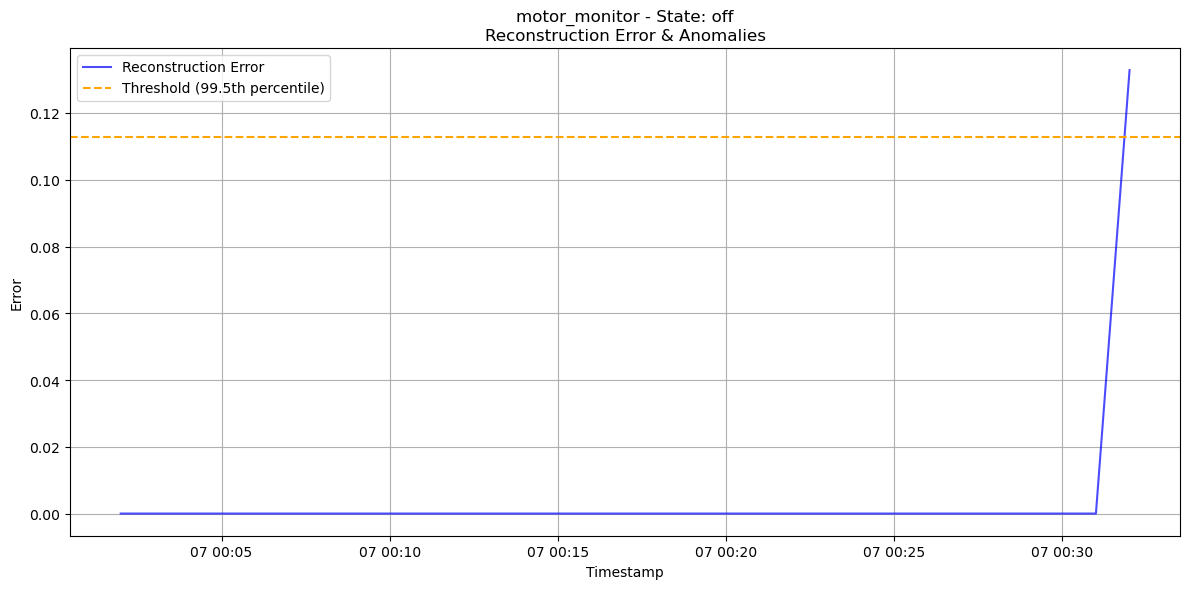

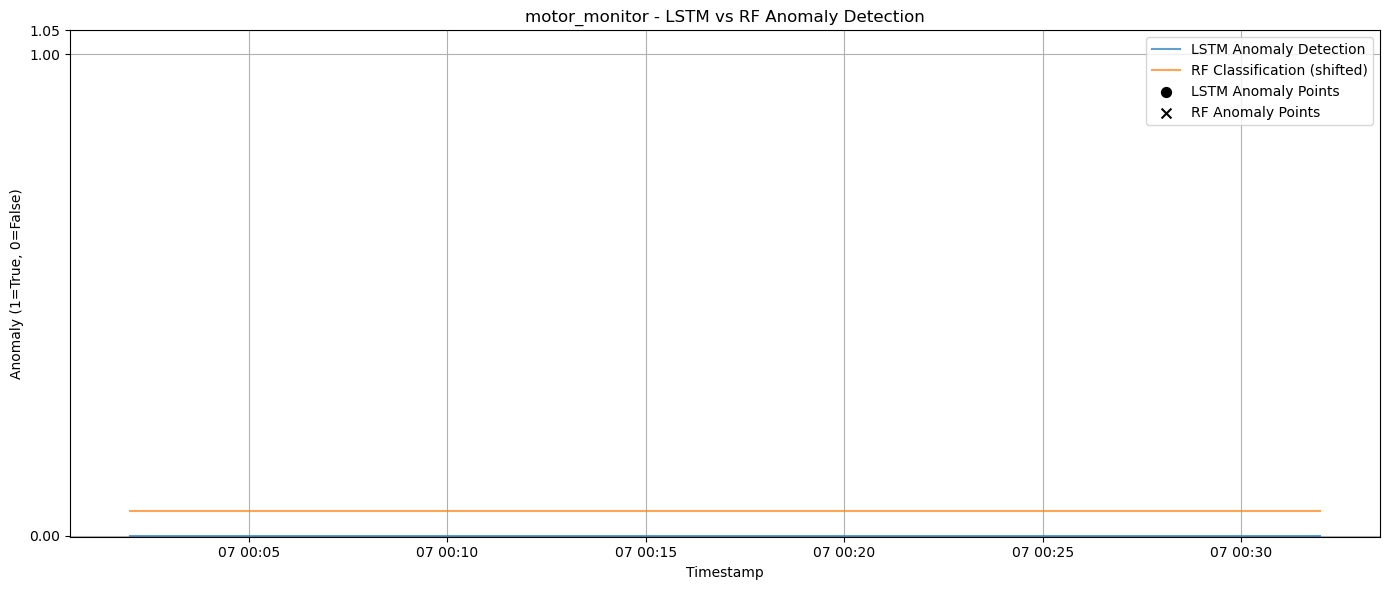

✅ Finished motor_monitor in 0.50 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:02:00   off  Normal       False  2.264510  2.697174   
1  2025-04-07 00:03:00   off  Normal       False  2.701560  2.591071   
2  2025-04-07 00:04:00   off  Normal       False  2.490280  2.602434   
3  2025-04-07 00:05:00   off  Normal       False  2.708476  2.703357   
4  2025-04-07 00:06:00   off  Normal       False  2.435889  2.205547   
5  2025-04-07 00:07:00   off  Normal       False  2.534185  2.541862   
6  2025-04-07 00:08:00   off  Normal       False  2.631539  2.616964   
7  2025-04-07 00:09:00   off  Normal       False  2.298811  2.824533   
8  2025-04-07 00:10:00   off  Normal       False  2.451170  2.820477   
9  2025-04-07 00:11:00   off  Normal       False  2.588191  2.695375   
10 2025-04-07 00:12:00   off  Normal       False  2.659420  2.182102   
11 2025-04-07 00:13:00   off  Normal       False  2.407113  2.313871   
12 2025

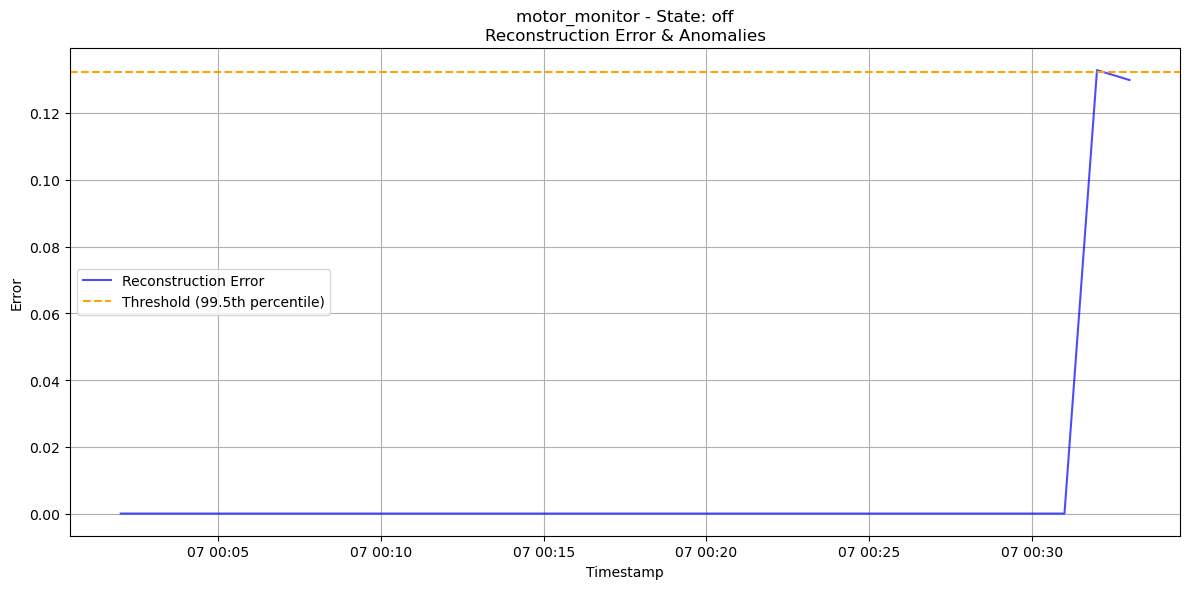

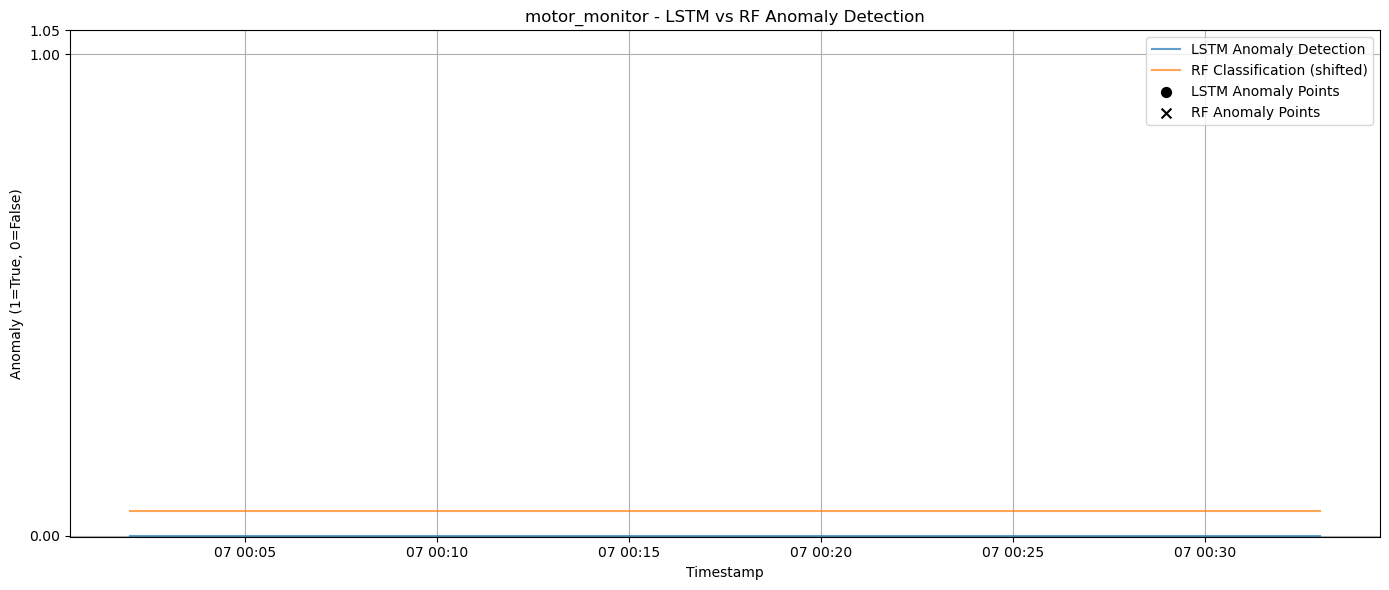

✅ Finished motor_monitor in 0.50 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:02:00   off  Normal       False  2.264510  2.697174   
1  2025-04-07 00:03:00   off  Normal       False  2.701560  2.591071   
2  2025-04-07 00:04:00   off  Normal       False  2.490280  2.602434   
3  2025-04-07 00:05:00   off  Normal       False  2.708476  2.703357   
4  2025-04-07 00:06:00   off  Normal       False  2.435889  2.205547   
5  2025-04-07 00:07:00   off  Normal       False  2.534185  2.541862   
6  2025-04-07 00:08:00   off  Normal       False  2.631539  2.616964   
7  2025-04-07 00:09:00   off  Normal       False  2.298811  2.824533   
8  2025-04-07 00:10:00   off  Normal       False  2.451170  2.820477   
9  2025-04-07 00:11:00   off  Normal       False  2.588191  2.695375   
10 2025-04-07 00:12:00   off  Normal       False  2.659420  2.182102   
11 2025-04-07 00:13:00   off  Normal       False  2.407113  2.313871   
12 2025

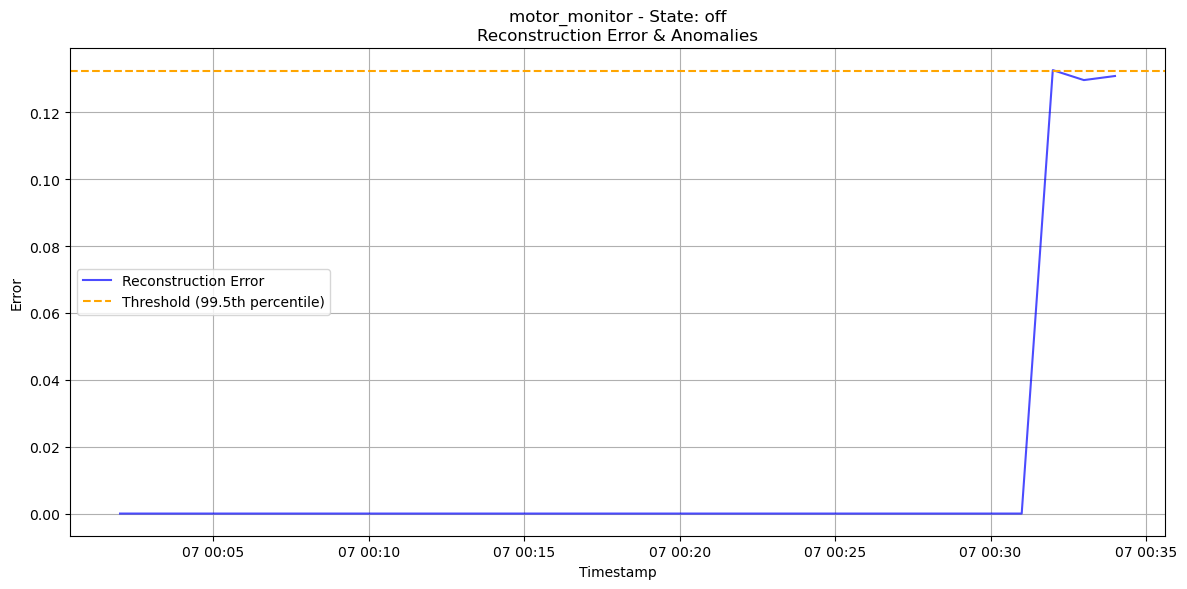

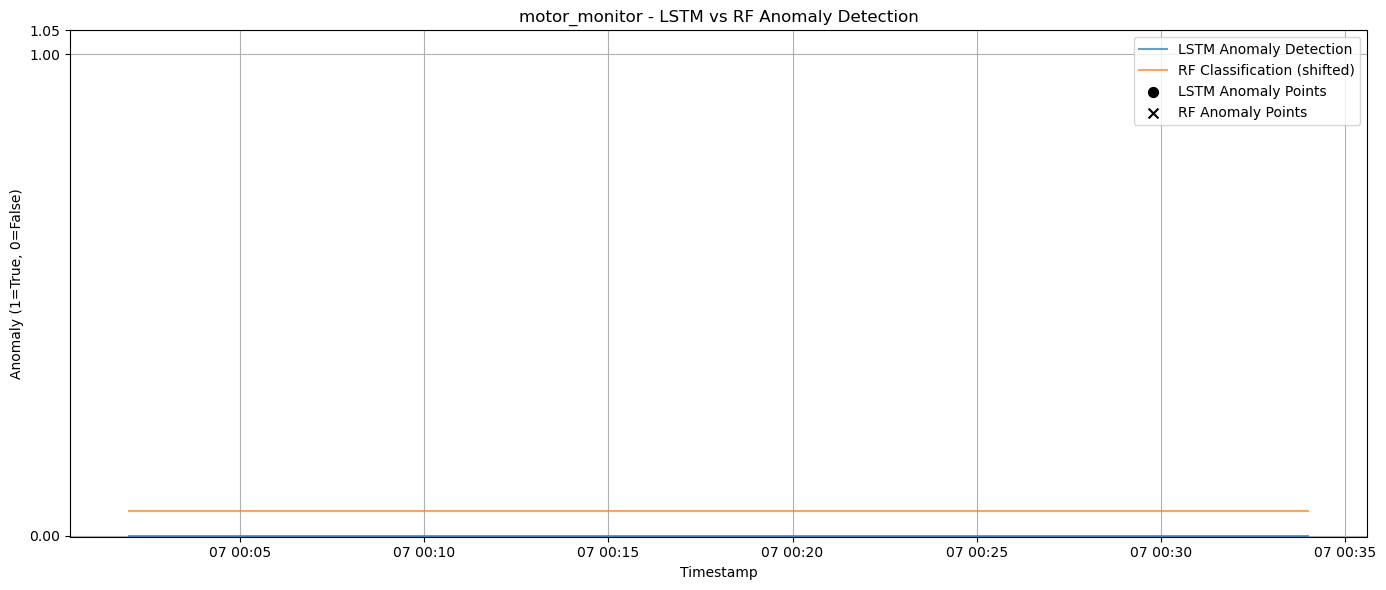

✅ Finished motor_monitor in 0.51 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:02:00   off  Normal       False  2.264510  2.697174   
1  2025-04-07 00:03:00   off  Normal       False  2.701560  2.591071   
2  2025-04-07 00:04:00   off  Normal       False  2.490280  2.602434   
3  2025-04-07 00:05:00   off  Normal       False  2.708476  2.703357   
4  2025-04-07 00:06:00   off  Normal       False  2.435889  2.205547   
5  2025-04-07 00:07:00   off  Normal       False  2.534185  2.541862   
6  2025-04-07 00:08:00   off  Normal       False  2.631539  2.616964   
7  2025-04-07 00:09:00   off  Normal       False  2.298811  2.824533   
8  2025-04-07 00:10:00   off  Normal       False  2.451170  2.820477   
9  2025-04-07 00:11:00   off  Normal       False  2.588191  2.695375   
10 2025-04-07 00:12:00   off  Normal       False  2.659420  2.182102   
11 2025-04-07 00:13:00   off  Normal       False  2.407113  2.313871   
12 2025

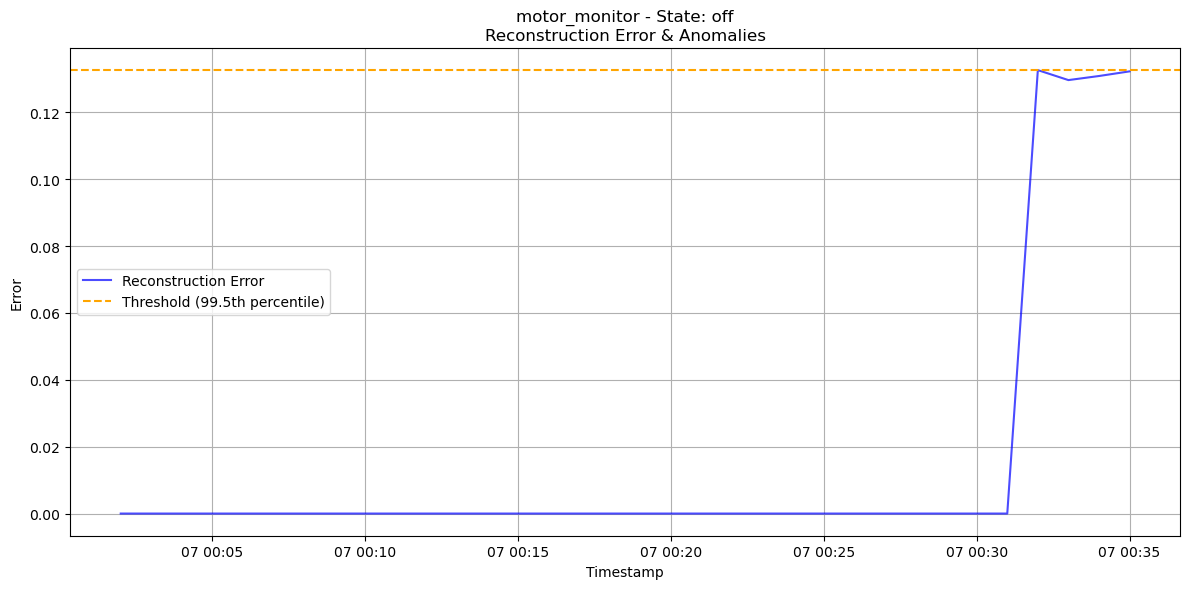

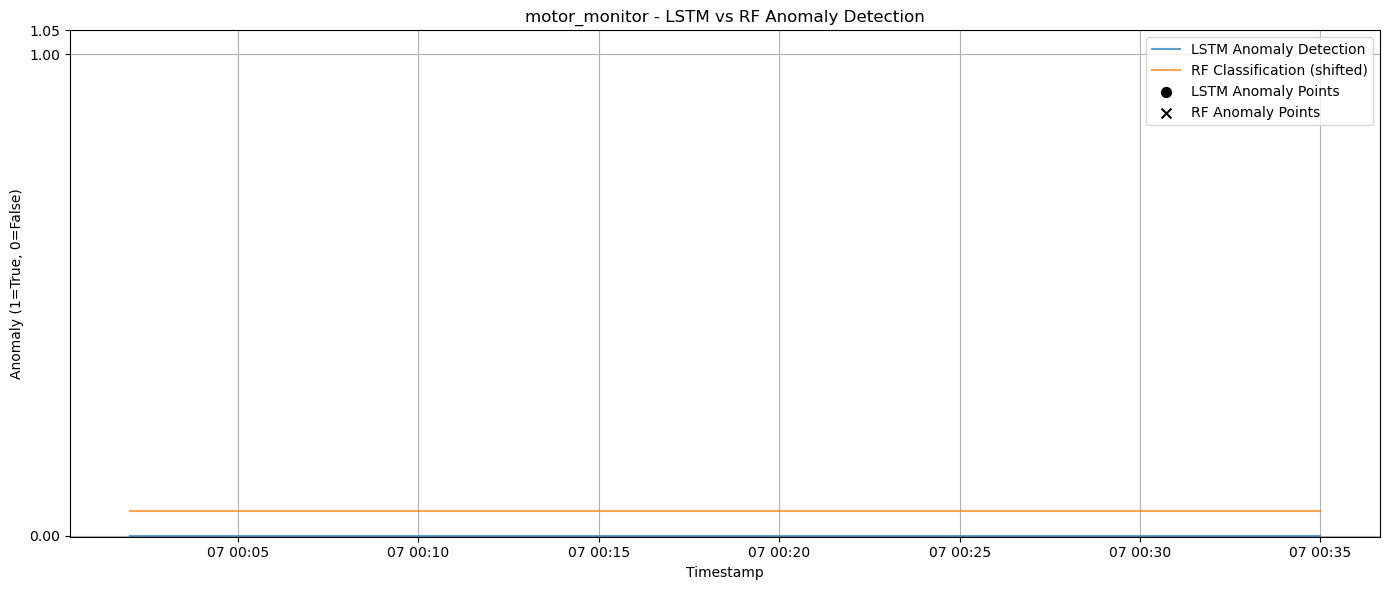

✅ Finished motor_monitor in 0.51 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:02:00   off  Normal       False  2.264510  2.697174   
1  2025-04-07 00:03:00   off  Normal       False  2.701560  2.591071   
2  2025-04-07 00:04:00   off  Normal       False  2.490280  2.602434   
3  2025-04-07 00:05:00   off  Normal       False  2.708476  2.703357   
4  2025-04-07 00:06:00   off  Normal       False  2.435889  2.205547   
5  2025-04-07 00:07:00   off  Normal       False  2.534185  2.541862   
6  2025-04-07 00:08:00   off  Normal       False  2.631539  2.616964   
7  2025-04-07 00:09:00   off  Normal       False  2.298811  2.824533   
8  2025-04-07 00:10:00   off  Normal       False  2.451170  2.820477   
9  2025-04-07 00:11:00   off  Normal       False  2.588191  2.695375   
10 2025-04-07 00:12:00   off  Normal       False  2.659420  2.182102   
11 2025-04-07 00:13:00   off  Normal       False  2.407113  2.313871   
12 2025

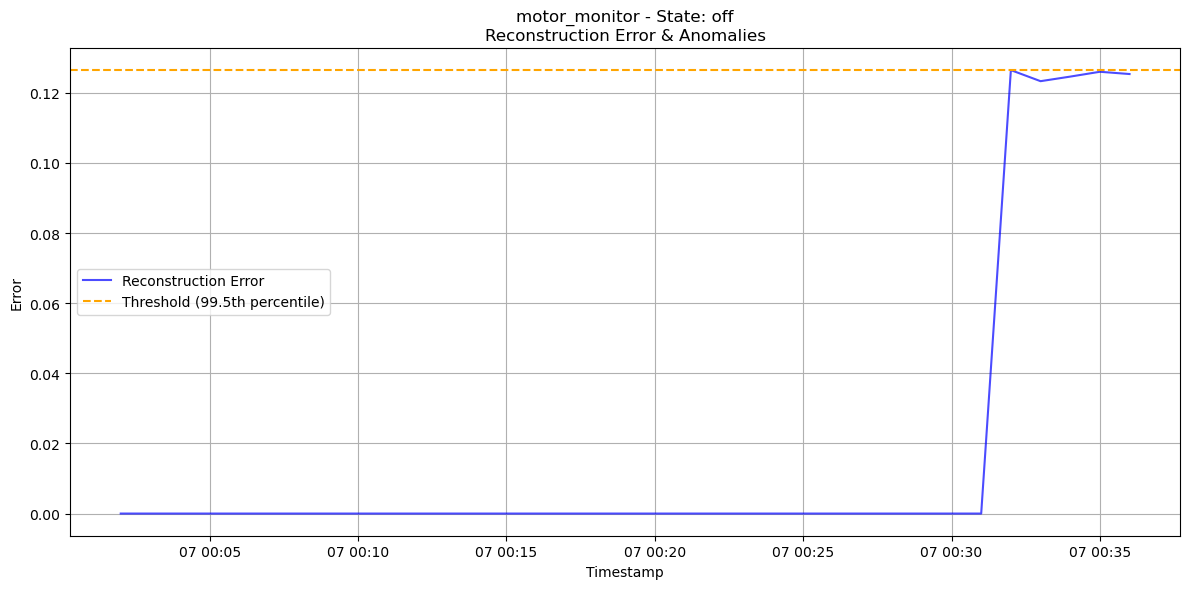

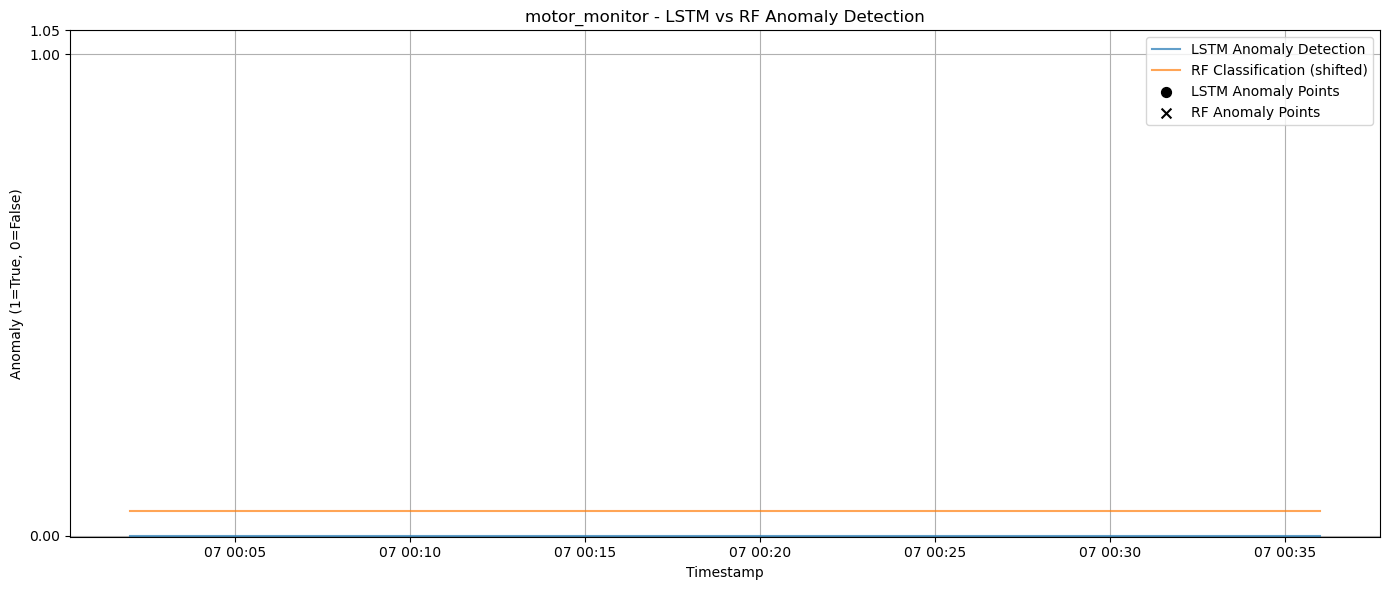

✅ Finished motor_monitor in 0.51 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:02:00   off  Normal       False  2.264510  2.697174   
1  2025-04-07 00:03:00   off  Normal       False  2.701560  2.591071   
2  2025-04-07 00:04:00   off  Normal       False  2.490280  2.602434   
3  2025-04-07 00:05:00   off  Normal       False  2.708476  2.703357   
4  2025-04-07 00:06:00   off  Normal       False  2.435889  2.205547   
5  2025-04-07 00:07:00   off  Normal       False  2.534185  2.541862   
6  2025-04-07 00:08:00   off  Normal       False  2.631539  2.616964   
7  2025-04-07 00:09:00   off  Normal       False  2.298811  2.824533   
8  2025-04-07 00:10:00   off  Normal       False  2.451170  2.820477   
9  2025-04-07 00:11:00   off  Normal       False  2.588191  2.695375   
10 2025-04-07 00:12:00   off  Normal       False  2.659420  2.182102   
11 2025-04-07 00:13:00   off  Normal       False  2.407113  2.313871   
12 2025

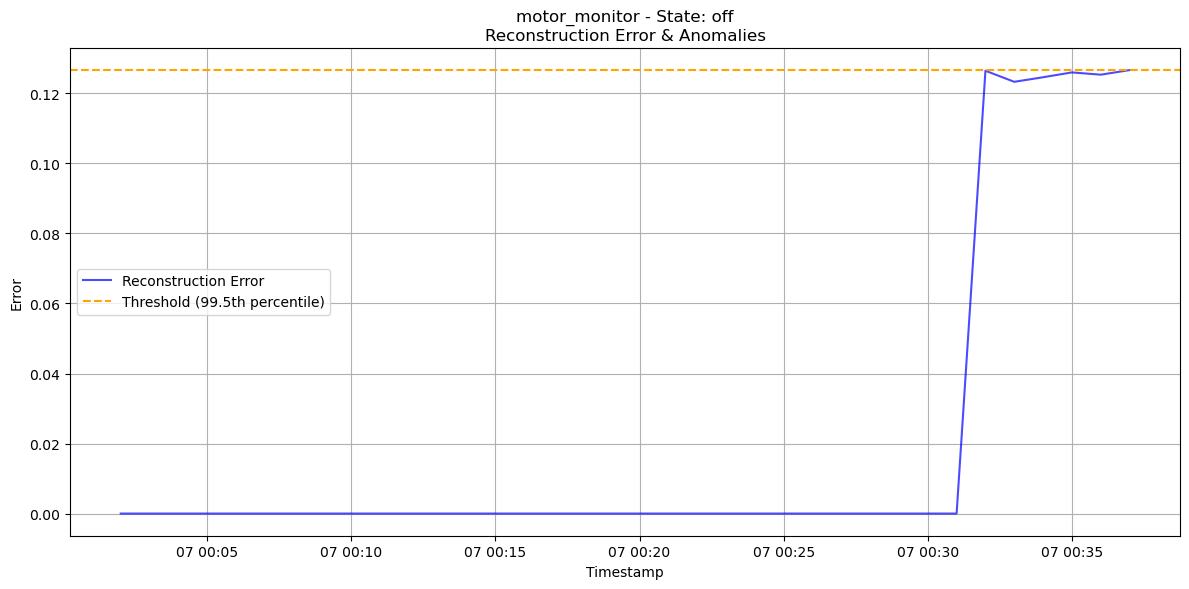

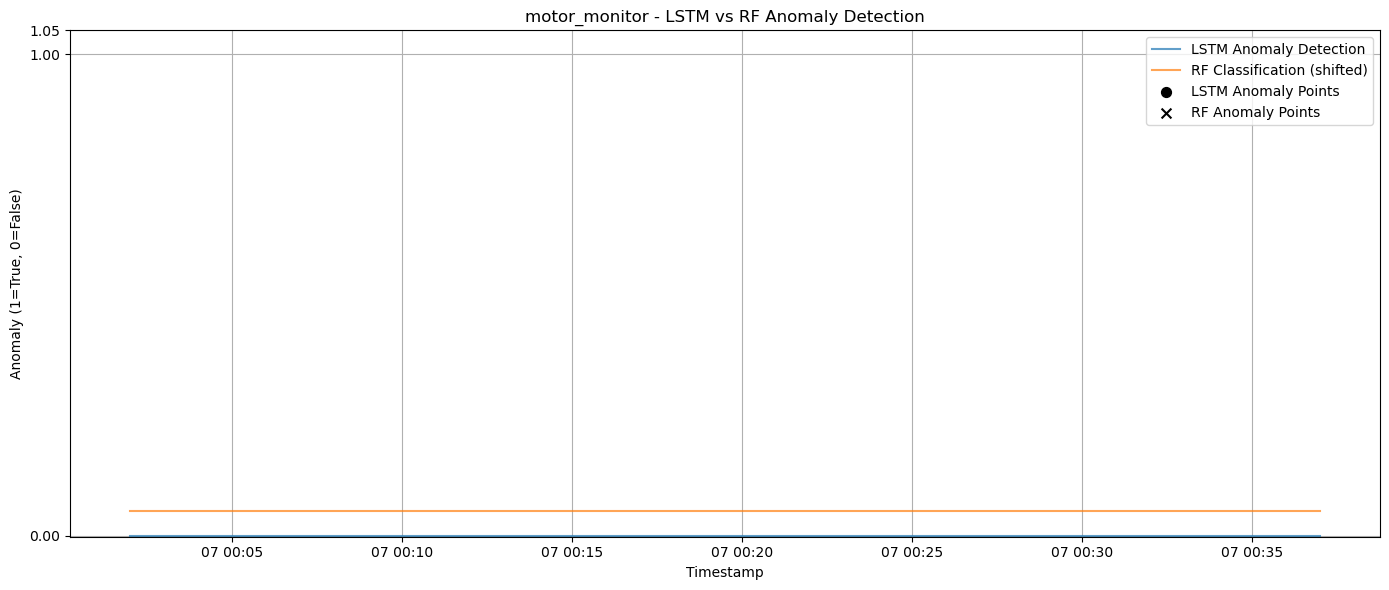

✅ Finished motor_monitor in 0.51 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:02:00   off  Normal       False  2.264510  2.697174   
1  2025-04-07 00:03:00   off  Normal       False  2.701560  2.591071   
2  2025-04-07 00:04:00   off  Normal       False  2.490280  2.602434   
3  2025-04-07 00:05:00   off  Normal       False  2.708476  2.703357   
4  2025-04-07 00:06:00   off  Normal       False  2.435889  2.205547   
5  2025-04-07 00:07:00   off  Normal       False  2.534185  2.541862   
6  2025-04-07 00:08:00   off  Normal       False  2.631539  2.616964   
7  2025-04-07 00:09:00   off  Normal       False  2.298811  2.824533   
8  2025-04-07 00:10:00   off  Normal       False  2.451170  2.820477   
9  2025-04-07 00:11:00   off  Normal       False  2.588191  2.695375   
10 2025-04-07 00:12:00   off  Normal       False  2.659420  2.182102   
11 2025-04-07 00:13:00   off  Normal       False  2.407113  2.313871   
12 2025

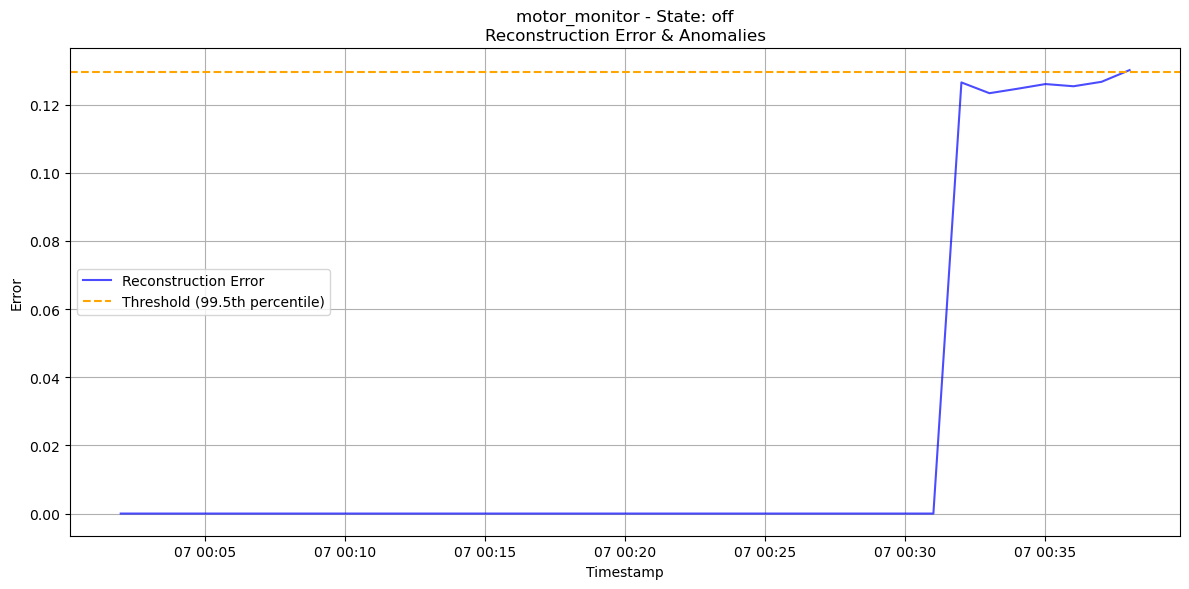

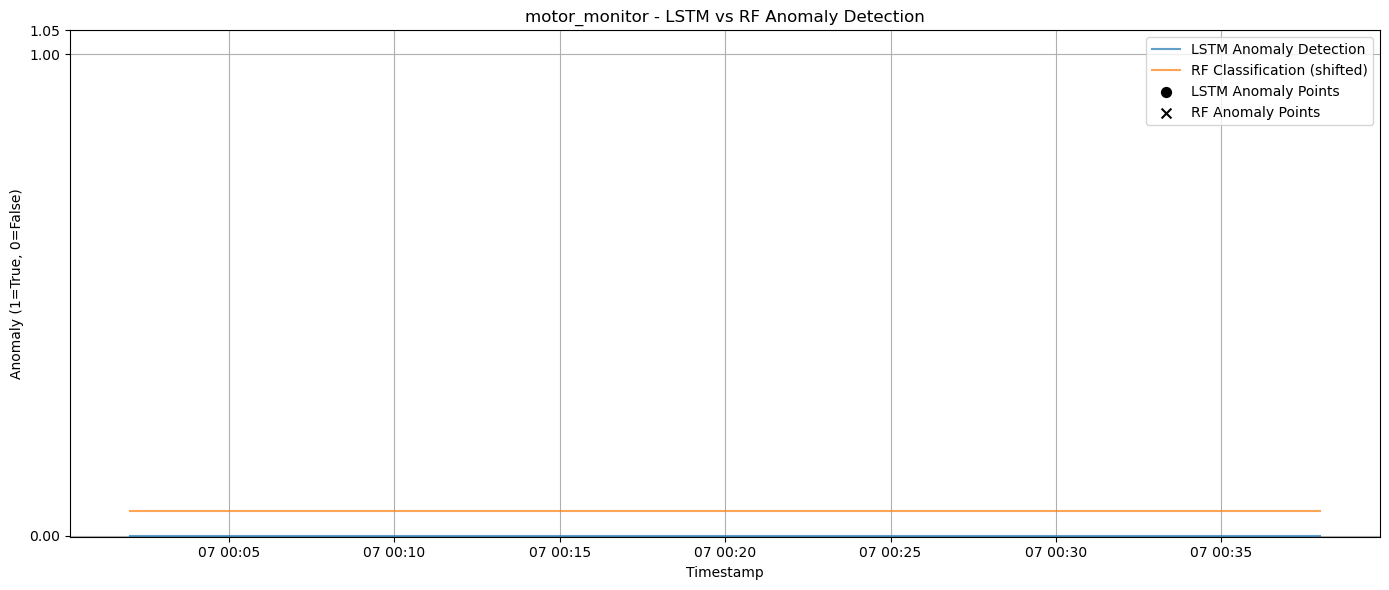

✅ Finished motor_monitor in 0.53 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:02:00   off  Normal       False  2.264510  2.697174   
1  2025-04-07 00:03:00   off  Normal       False  2.701560  2.591071   
2  2025-04-07 00:04:00   off  Normal       False  2.490280  2.602434   
3  2025-04-07 00:05:00   off  Normal       False  2.708476  2.703357   
4  2025-04-07 00:06:00   off  Normal       False  2.435889  2.205547   
5  2025-04-07 00:07:00   off  Normal       False  2.534185  2.541862   
6  2025-04-07 00:08:00   off  Normal       False  2.631539  2.616964   
7  2025-04-07 00:09:00   off  Normal       False  2.298811  2.824533   
8  2025-04-07 00:10:00   off  Normal       False  2.451170  2.820477   
9  2025-04-07 00:11:00   off  Normal       False  2.588191  2.695375   
10 2025-04-07 00:12:00   off  Normal       False  2.659420  2.182102   
11 2025-04-07 00:13:00   off  Normal       False  2.407113  2.313871   
12 2025

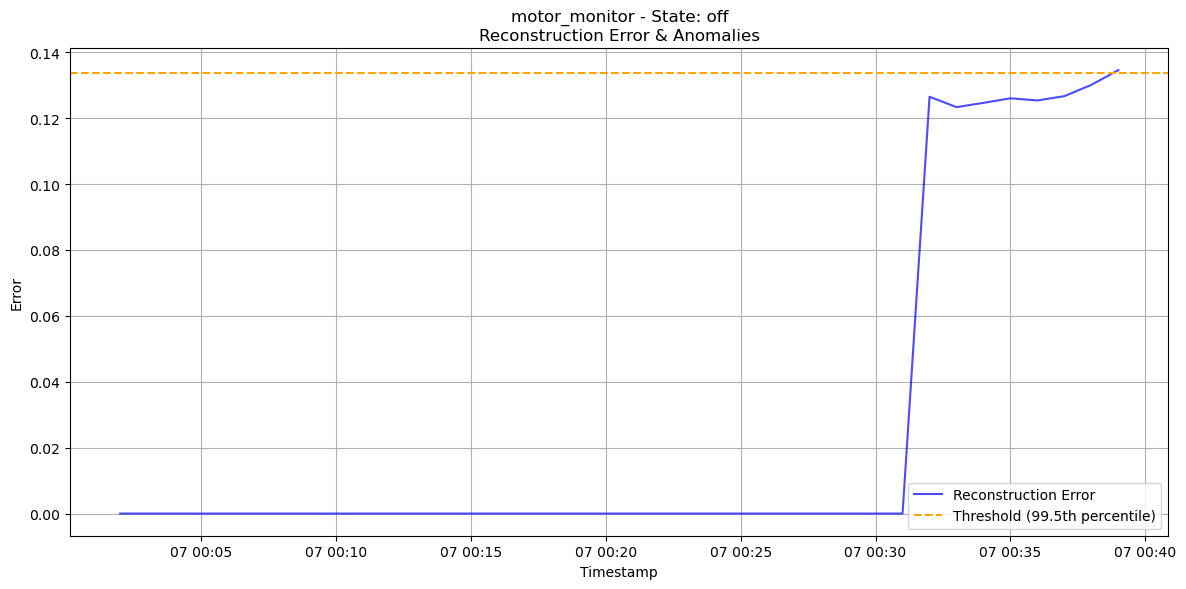

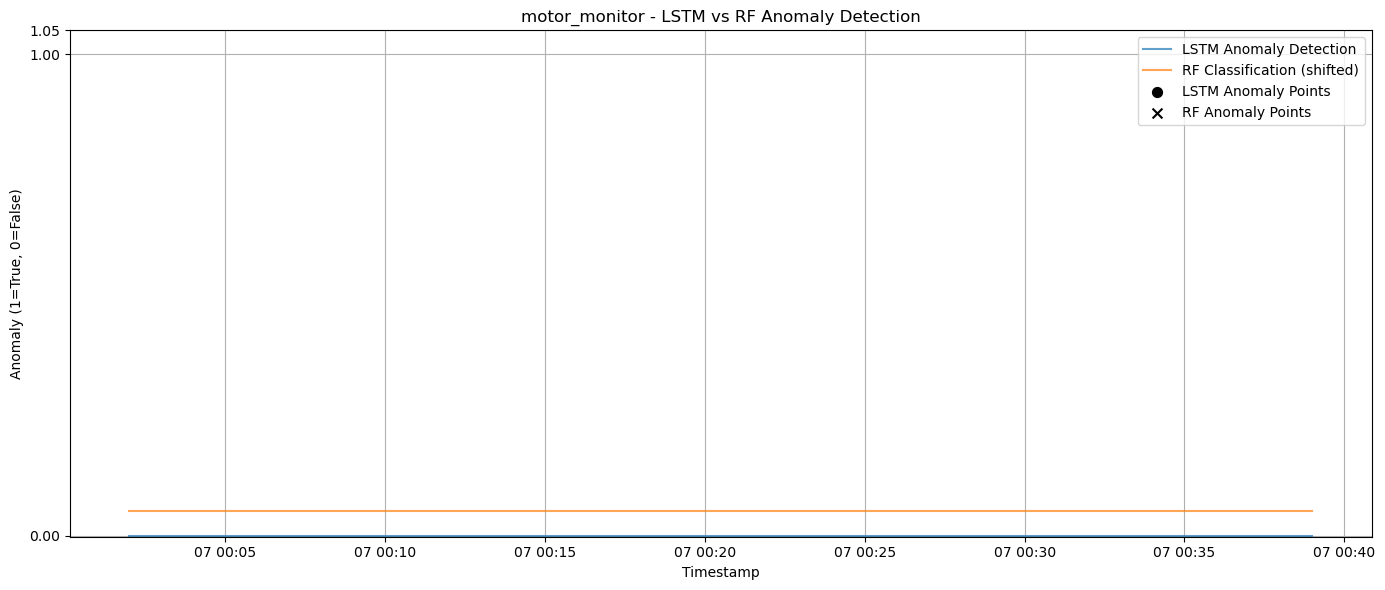

✅ Finished motor_monitor in 0.50 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:02:00   off  Normal       False  2.264510  2.697174   
1  2025-04-07 00:03:00   off  Normal       False  2.701560  2.591071   
2  2025-04-07 00:04:00   off  Normal       False  2.490280  2.602434   
3  2025-04-07 00:05:00   off  Normal       False  2.708476  2.703357   
4  2025-04-07 00:06:00   off  Normal       False  2.435889  2.205547   
5  2025-04-07 00:07:00   off  Normal       False  2.534185  2.541862   
6  2025-04-07 00:08:00   off  Normal       False  2.631539  2.616964   
7  2025-04-07 00:09:00   off  Normal       False  2.298811  2.824533   
8  2025-04-07 00:10:00   off  Normal       False  2.451170  2.820477   
9  2025-04-07 00:11:00   off  Normal       False  2.588191  2.695375   
10 2025-04-07 00:12:00   off  Normal       False  2.659420  2.182102   
11 2025-04-07 00:13:00   off  Normal       False  2.407113  2.313871   
12 2025

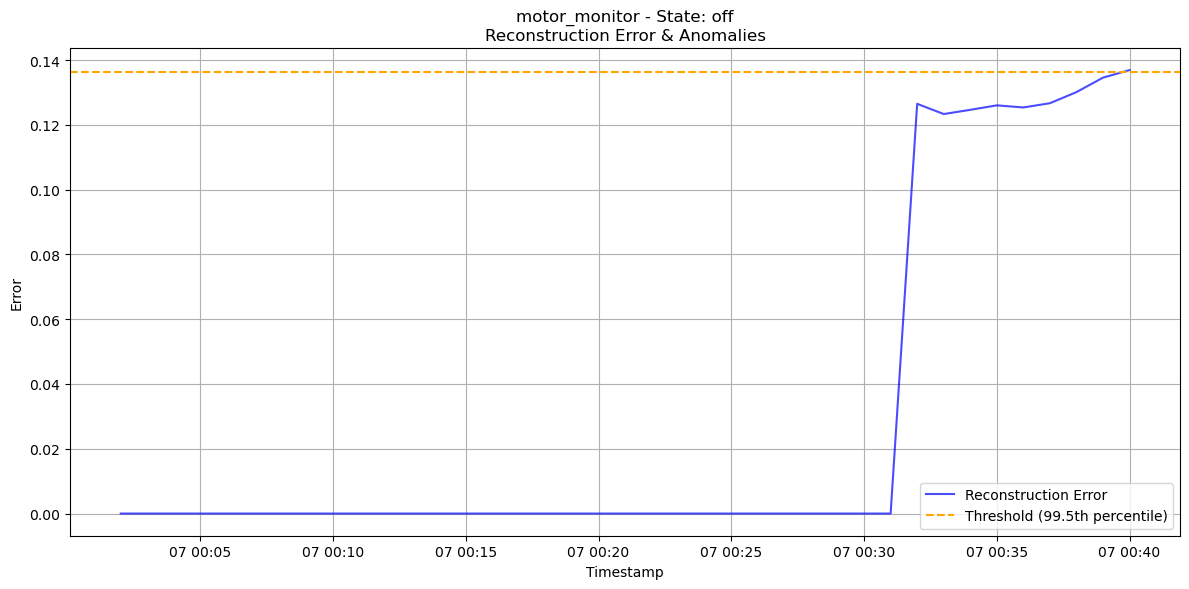

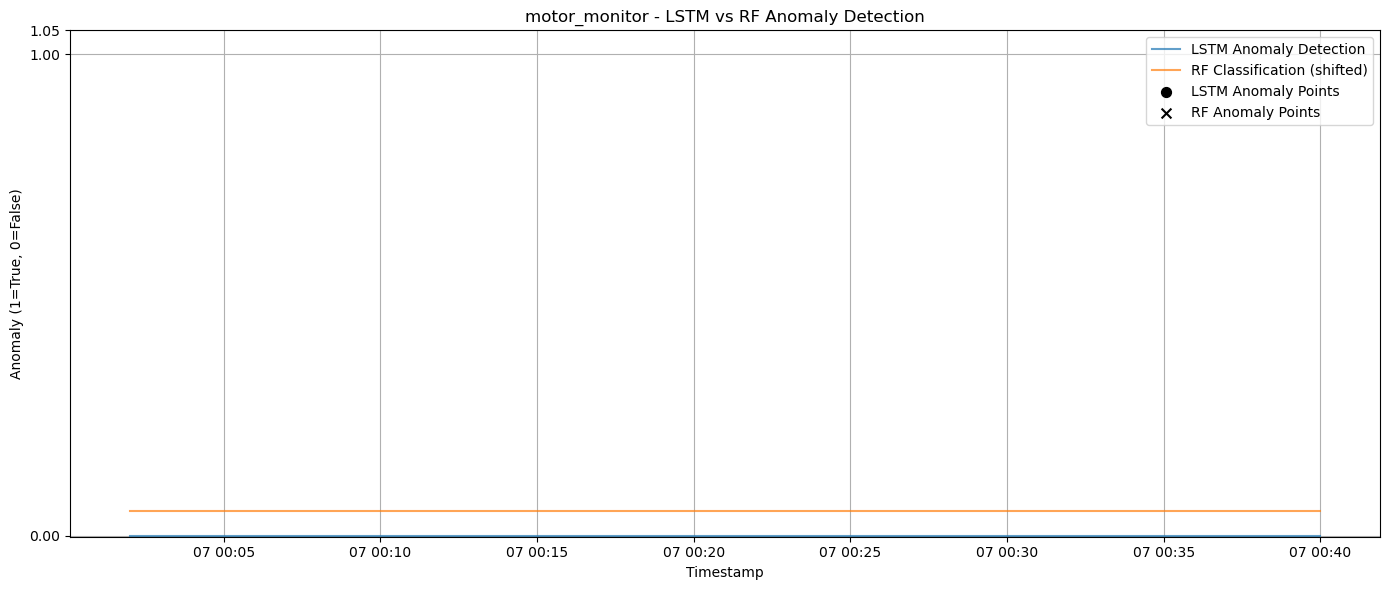

✅ Finished motor_monitor in 0.51 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:02:00   off  Normal       False  2.264510  2.697174   
1  2025-04-07 00:03:00   off  Normal       False  2.701560  2.591071   
2  2025-04-07 00:04:00   off  Normal       False  2.490280  2.602434   
3  2025-04-07 00:05:00   off  Normal       False  2.708476  2.703357   
4  2025-04-07 00:06:00   off  Normal       False  2.435889  2.205547   
5  2025-04-07 00:07:00   off  Normal       False  2.534185  2.541862   
6  2025-04-07 00:08:00   off  Normal       False  2.631539  2.616964   
7  2025-04-07 00:09:00   off  Normal       False  2.298811  2.824533   
8  2025-04-07 00:10:00   off  Normal       False  2.451170  2.820477   
9  2025-04-07 00:11:00   off  Normal       False  2.588191  2.695375   
10 2025-04-07 00:12:00   off  Normal       False  2.659420  2.182102   
11 2025-04-07 00:13:00   off  Normal       False  2.407113  2.313871   
12 2025

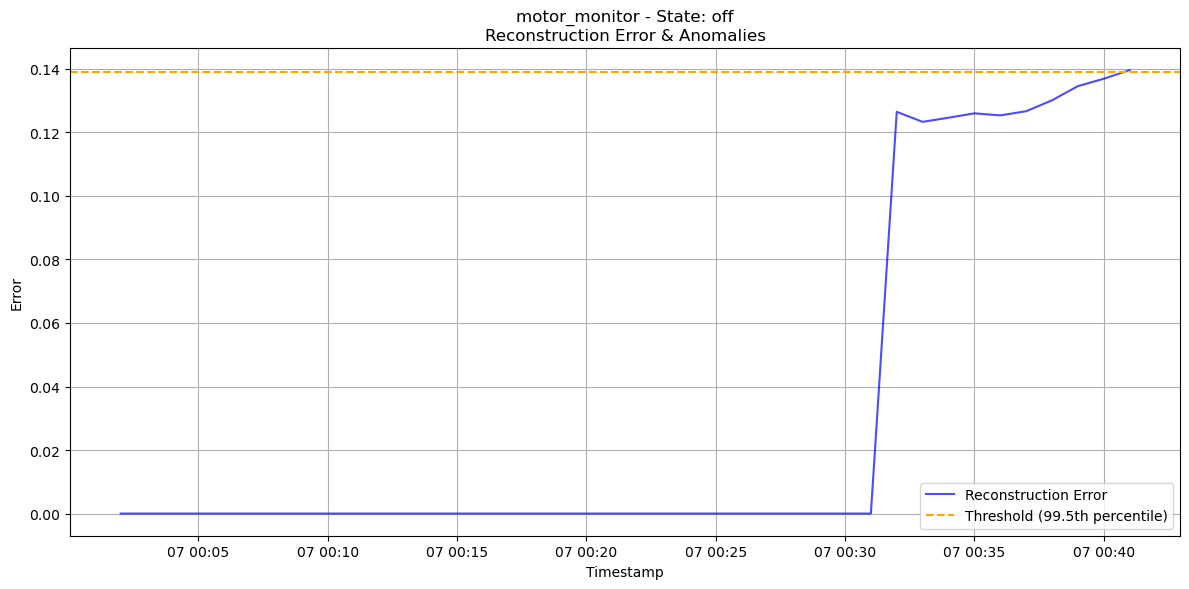

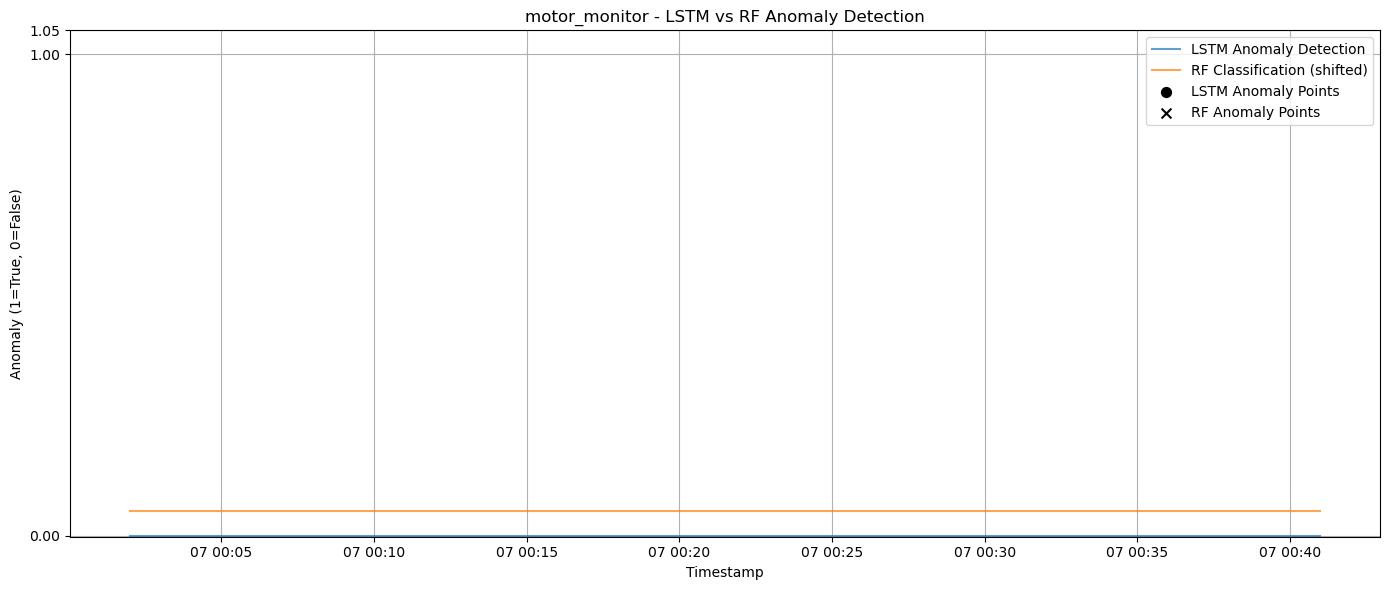

✅ Finished motor_monitor in 0.50 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:02:00   off  Normal       False  2.264510  2.697174   
1  2025-04-07 00:03:00   off  Normal       False  2.701560  2.591071   
2  2025-04-07 00:04:00   off  Normal       False  2.490280  2.602434   
3  2025-04-07 00:05:00   off  Normal       False  2.708476  2.703357   
4  2025-04-07 00:06:00   off  Normal       False  2.435889  2.205547   
5  2025-04-07 00:07:00   off  Normal       False  2.534185  2.541862   
6  2025-04-07 00:08:00   off  Normal       False  2.631539  2.616964   
7  2025-04-07 00:09:00   off  Normal       False  2.298811  2.824533   
8  2025-04-07 00:10:00   off  Normal       False  2.451170  2.820477   
9  2025-04-07 00:11:00   off  Normal       False  2.588191  2.695375   
10 2025-04-07 00:12:00   off  Normal       False  2.659420  2.182102   
11 2025-04-07 00:13:00   off  Normal       False  2.407113  2.313871   
12 2025

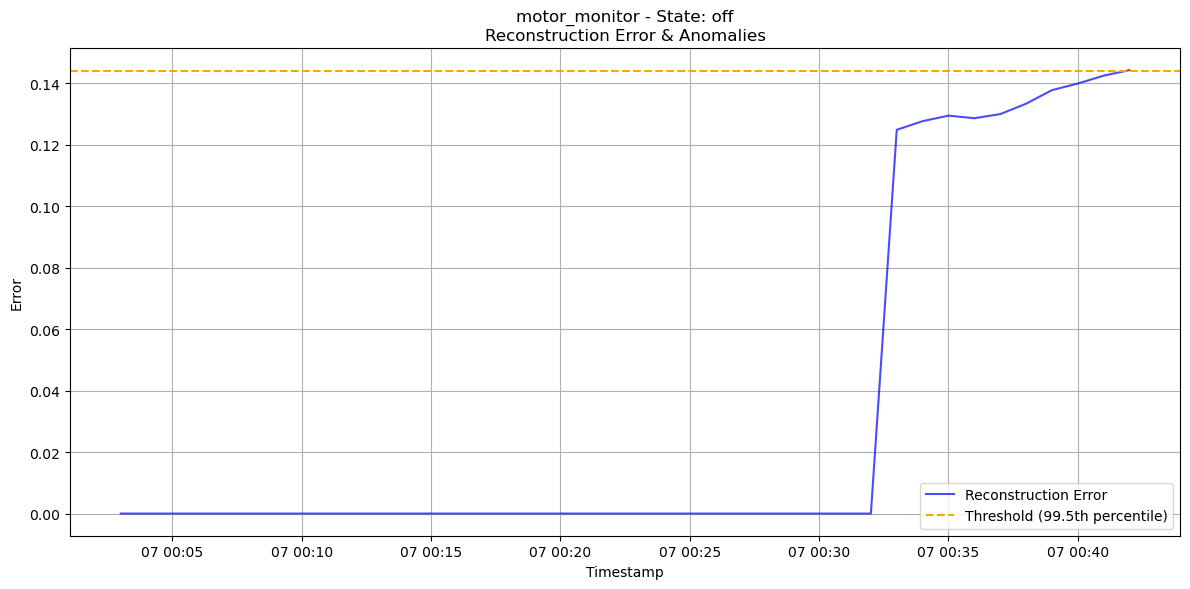

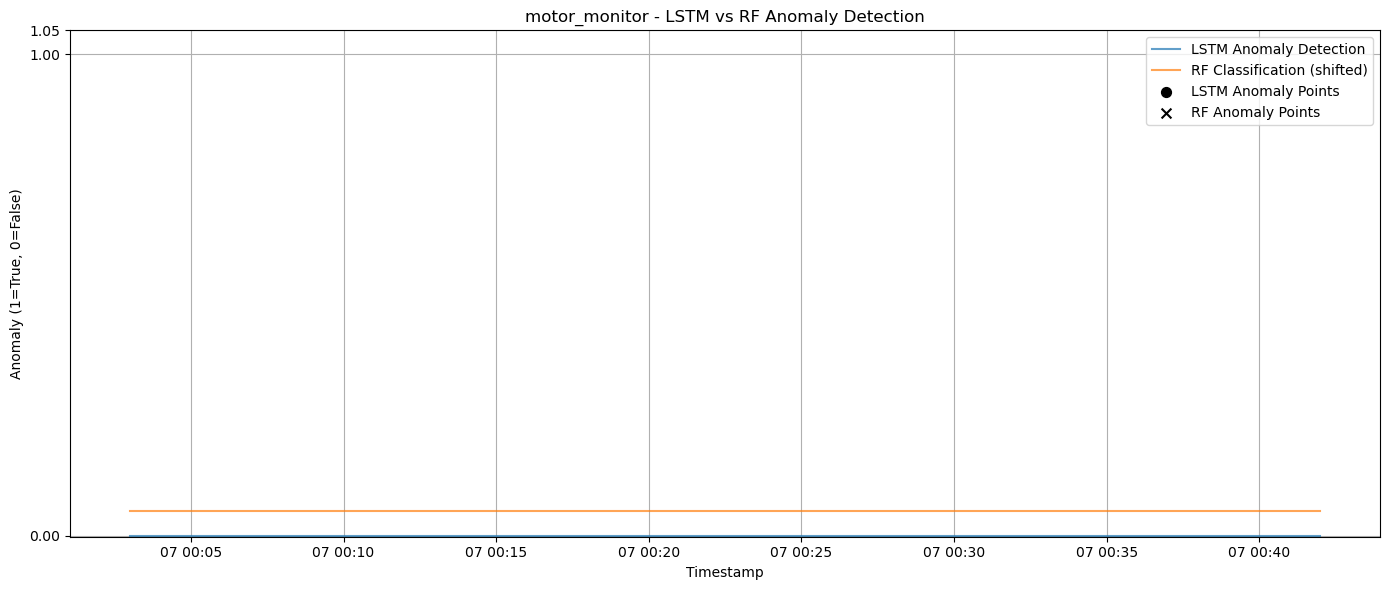

✅ Finished motor_monitor in 0.92 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:03:00   off  Normal       False  2.701560  2.591071   
1  2025-04-07 00:04:00   off  Normal       False  2.490280  2.602434   
2  2025-04-07 00:05:00   off  Normal       False  2.708476  2.703357   
3  2025-04-07 00:06:00   off  Normal       False  2.435889  2.205547   
4  2025-04-07 00:07:00   off  Normal       False  2.534185  2.541862   
5  2025-04-07 00:08:00   off  Normal       False  2.631539  2.616964   
6  2025-04-07 00:09:00   off  Normal       False  2.298811  2.824533   
7  2025-04-07 00:10:00   off  Normal       False  2.451170  2.820477   
8  2025-04-07 00:11:00   off  Normal       False  2.588191  2.695375   
9  2025-04-07 00:12:00   off  Normal       False  2.659420  2.182102   
10 2025-04-07 00:13:00   off  Normal       False  2.407113  2.313871   
11 2025-04-07 00:14:00   off  Normal       False  2.843730  2.769565   
12 2025

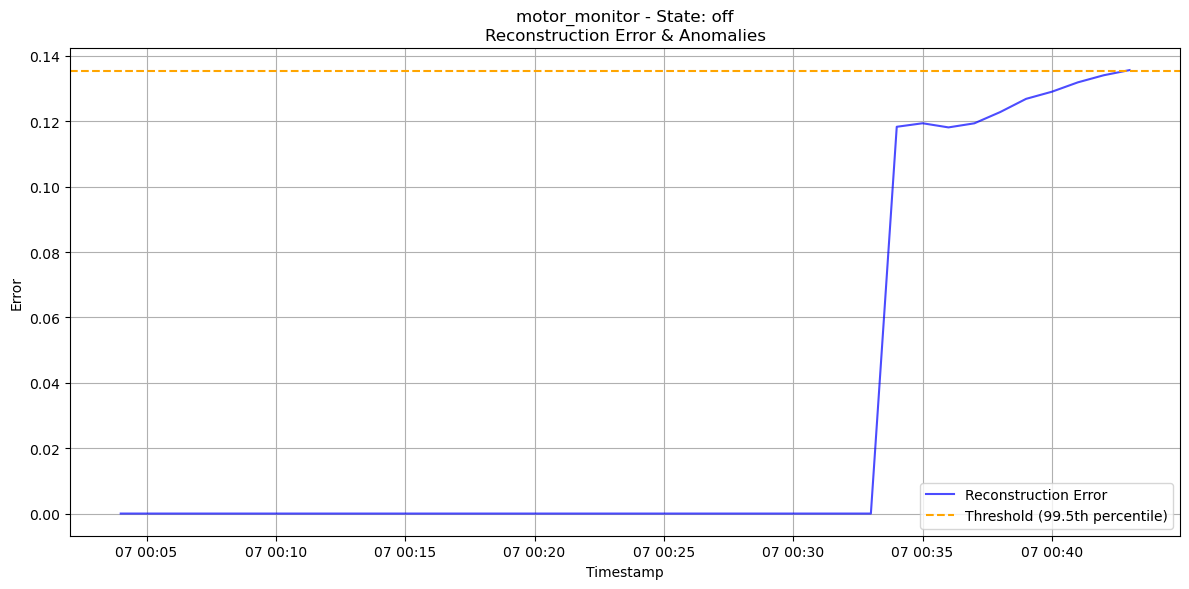

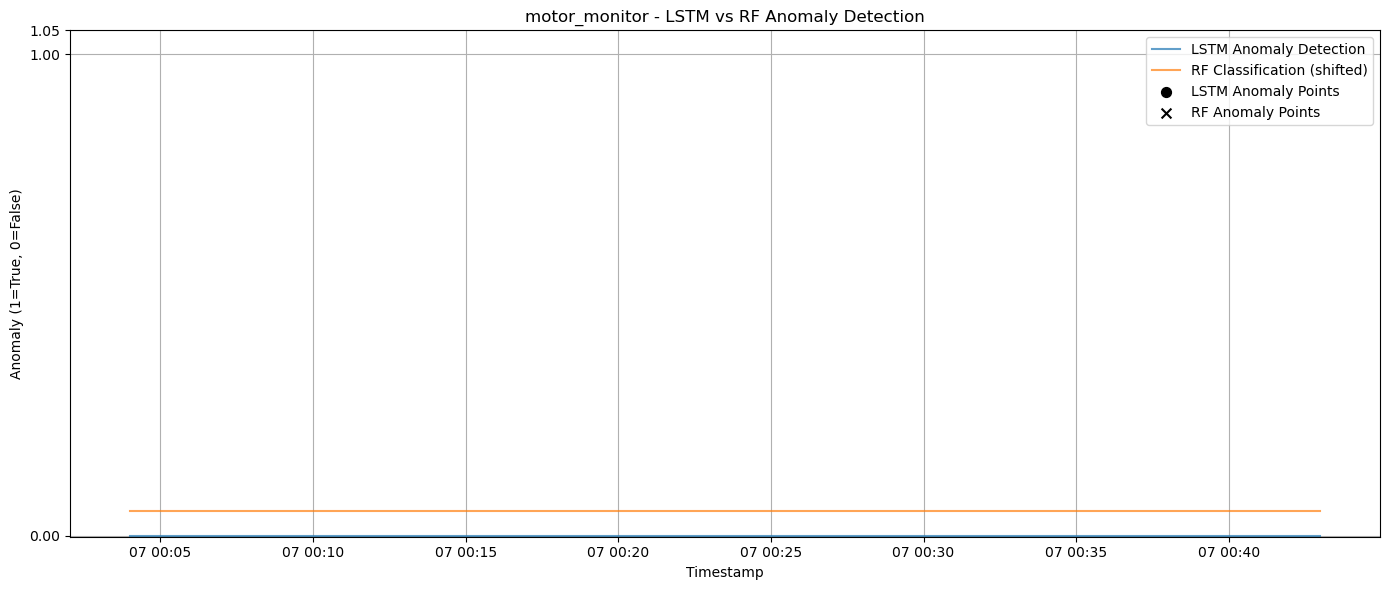

✅ Finished motor_monitor in 0.53 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:04:00   off  Normal       False  2.490280  2.602434   
1  2025-04-07 00:05:00   off  Normal       False  2.708476  2.703357   
2  2025-04-07 00:06:00   off  Normal       False  2.435889  2.205547   
3  2025-04-07 00:07:00   off  Normal       False  2.534185  2.541862   
4  2025-04-07 00:08:00   off  Normal       False  2.631539  2.616964   
5  2025-04-07 00:09:00   off  Normal       False  2.298811  2.824533   
6  2025-04-07 00:10:00   off  Normal       False  2.451170  2.820477   
7  2025-04-07 00:11:00   off  Normal       False  2.588191  2.695375   
8  2025-04-07 00:12:00   off  Normal       False  2.659420  2.182102   
9  2025-04-07 00:13:00   off  Normal       False  2.407113  2.313871   
10 2025-04-07 00:14:00   off  Normal       False  2.843730  2.769565   
11 2025-04-07 00:15:00   off  Normal       False  2.403367  2.770919   
12 2025

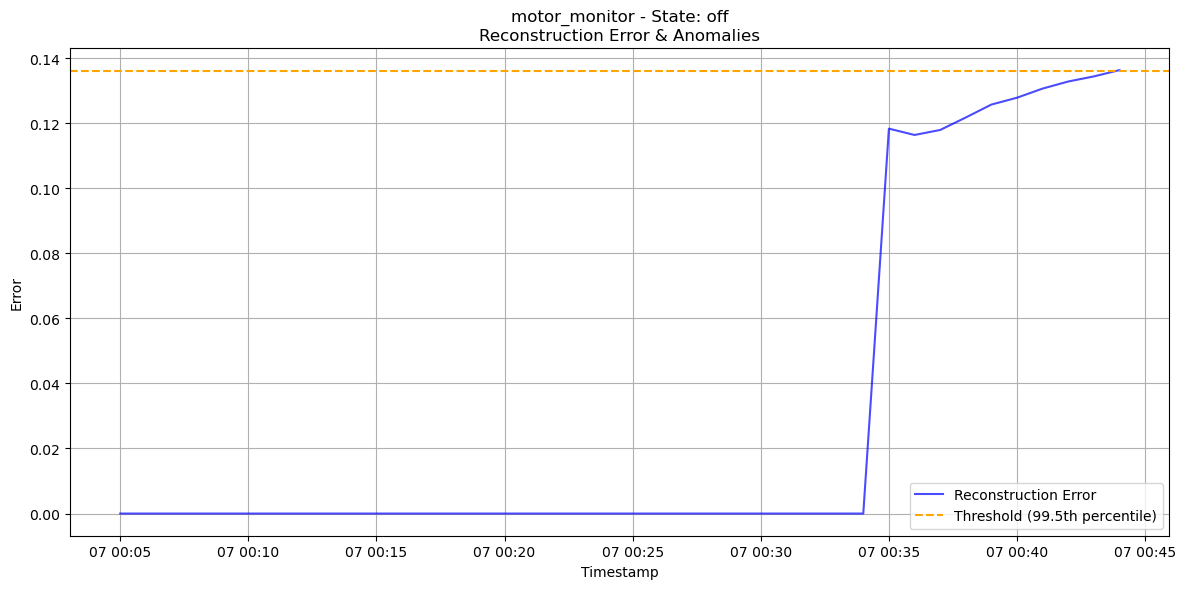

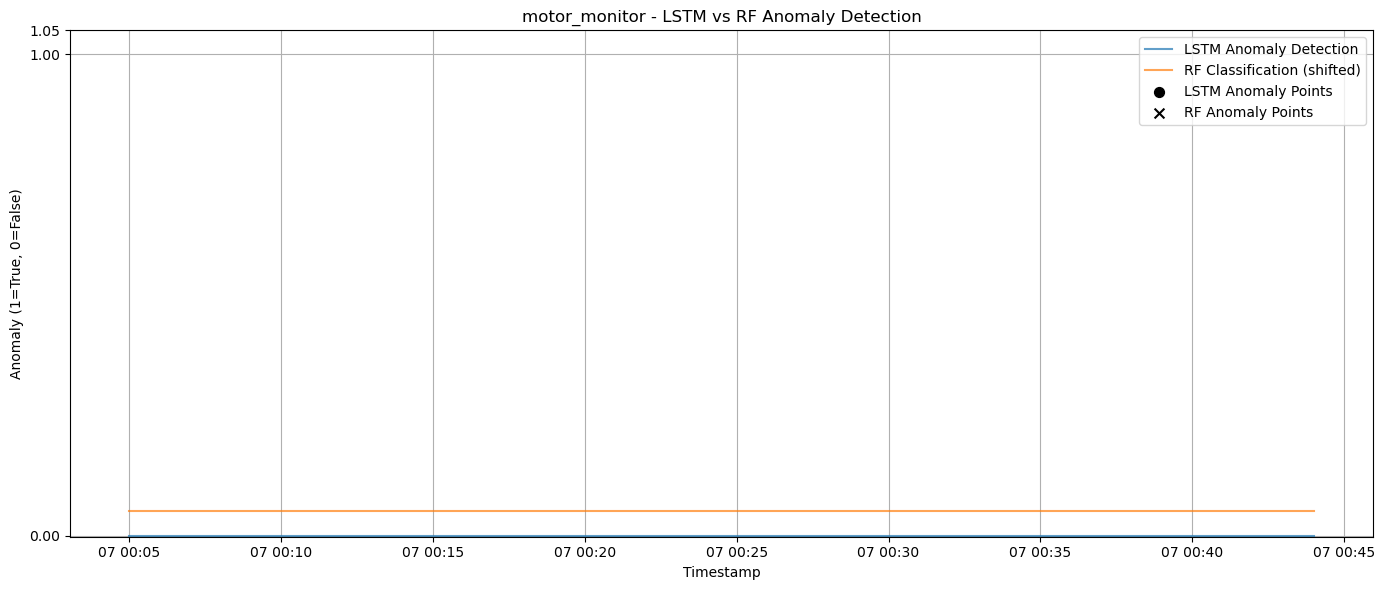

✅ Finished motor_monitor in 0.53 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:05:00   off  Normal       False  2.708476  2.703357   
1  2025-04-07 00:06:00   off  Normal       False  2.435889  2.205547   
2  2025-04-07 00:07:00   off  Normal       False  2.534185  2.541862   
3  2025-04-07 00:08:00   off  Normal       False  2.631539  2.616964   
4  2025-04-07 00:09:00   off  Normal       False  2.298811  2.824533   
5  2025-04-07 00:10:00   off  Normal       False  2.451170  2.820477   
6  2025-04-07 00:11:00   off  Normal       False  2.588191  2.695375   
7  2025-04-07 00:12:00   off  Normal       False  2.659420  2.182102   
8  2025-04-07 00:13:00   off  Normal       False  2.407113  2.313871   
9  2025-04-07 00:14:00   off  Normal       False  2.843730  2.769565   
10 2025-04-07 00:15:00   off  Normal       False  2.403367  2.770919   
11 2025-04-07 00:16:00   off  Normal       False  2.335112  2.218192   
12 2025

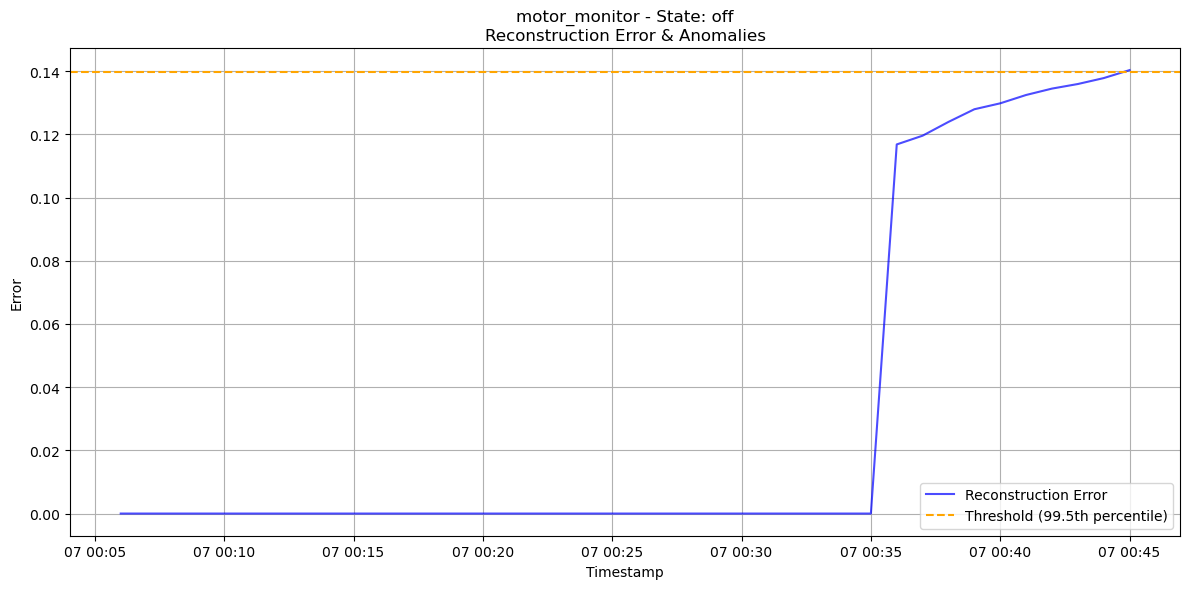

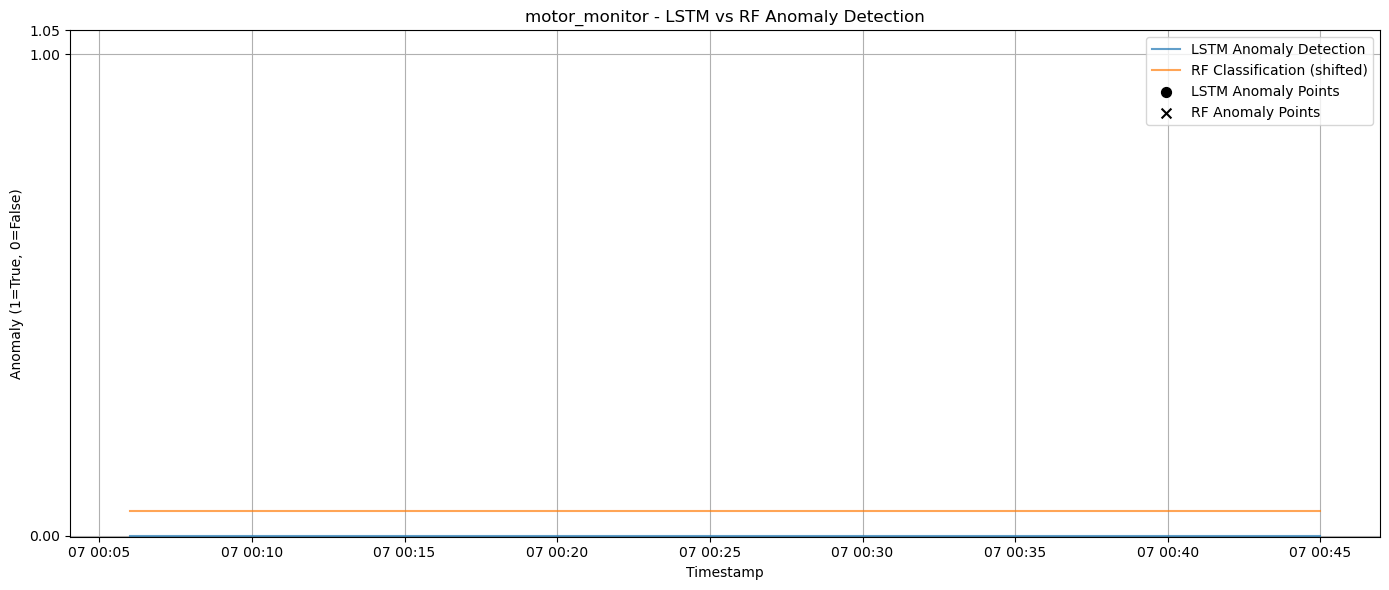

✅ Finished motor_monitor in 0.53 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:06:00   off  Normal       False  2.435889  2.205547   
1  2025-04-07 00:07:00   off  Normal       False  2.534185  2.541862   
2  2025-04-07 00:08:00   off  Normal       False  2.631539  2.616964   
3  2025-04-07 00:09:00   off  Normal       False  2.298811  2.824533   
4  2025-04-07 00:10:00   off  Normal       False  2.451170  2.820477   
5  2025-04-07 00:11:00   off  Normal       False  2.588191  2.695375   
6  2025-04-07 00:12:00   off  Normal       False  2.659420  2.182102   
7  2025-04-07 00:13:00   off  Normal       False  2.407113  2.313871   
8  2025-04-07 00:14:00   off  Normal       False  2.843730  2.769565   
9  2025-04-07 00:15:00   off  Normal       False  2.403367  2.770919   
10 2025-04-07 00:16:00   off  Normal       False  2.335112  2.218192   
11 2025-04-07 00:17:00   off  Normal       False  2.606865  2.475453   
12 2025

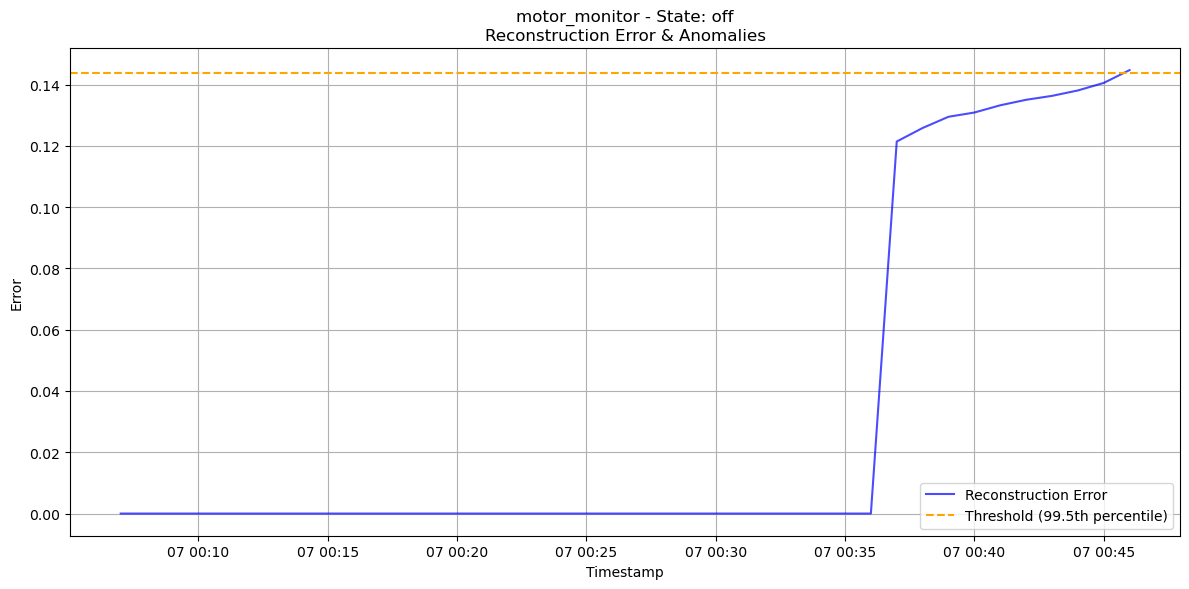

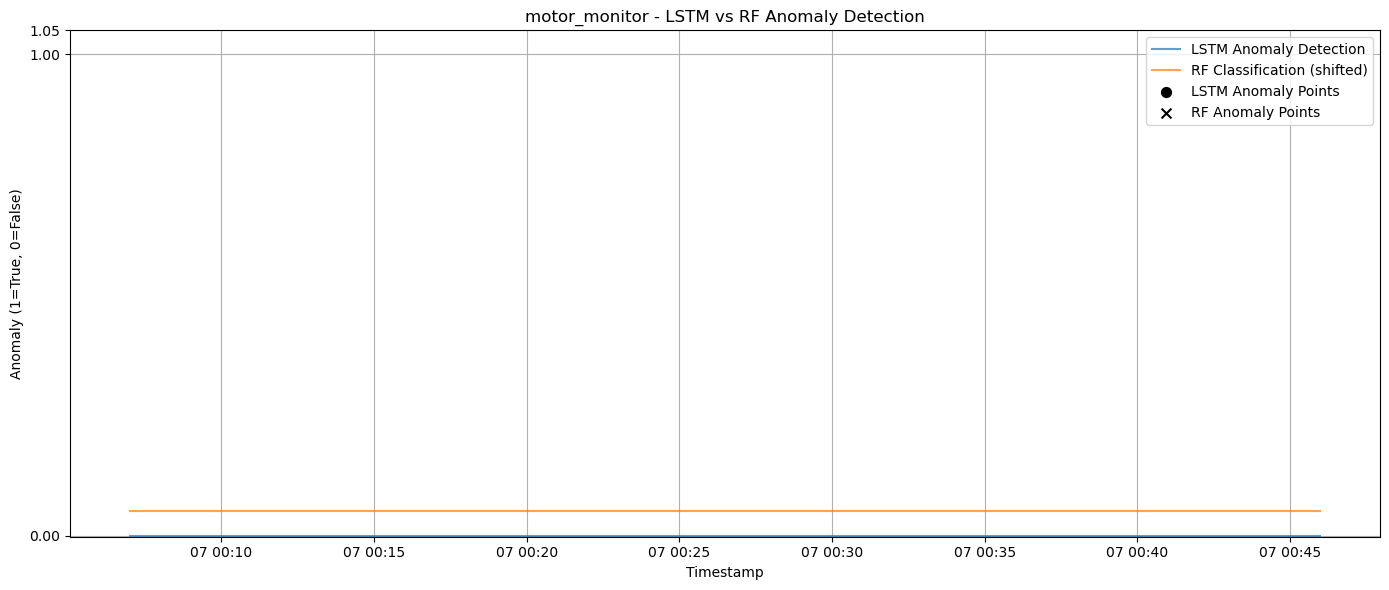

✅ Finished motor_monitor in 0.56 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:07:00   off  Normal       False  2.534185  2.541862   
1  2025-04-07 00:08:00   off  Normal       False  2.631539  2.616964   
2  2025-04-07 00:09:00   off  Normal       False  2.298811  2.824533   
3  2025-04-07 00:10:00   off  Normal       False  2.451170  2.820477   
4  2025-04-07 00:11:00   off  Normal       False  2.588191  2.695375   
5  2025-04-07 00:12:00   off  Normal       False  2.659420  2.182102   
6  2025-04-07 00:13:00   off  Normal       False  2.407113  2.313871   
7  2025-04-07 00:14:00   off  Normal       False  2.843730  2.769565   
8  2025-04-07 00:15:00   off  Normal       False  2.403367  2.770919   
9  2025-04-07 00:16:00   off  Normal       False  2.335112  2.218192   
10 2025-04-07 00:17:00   off  Normal       False  2.606865  2.475453   
11 2025-04-07 00:18:00   off  Normal       False  2.867416  2.449642   
12 2025

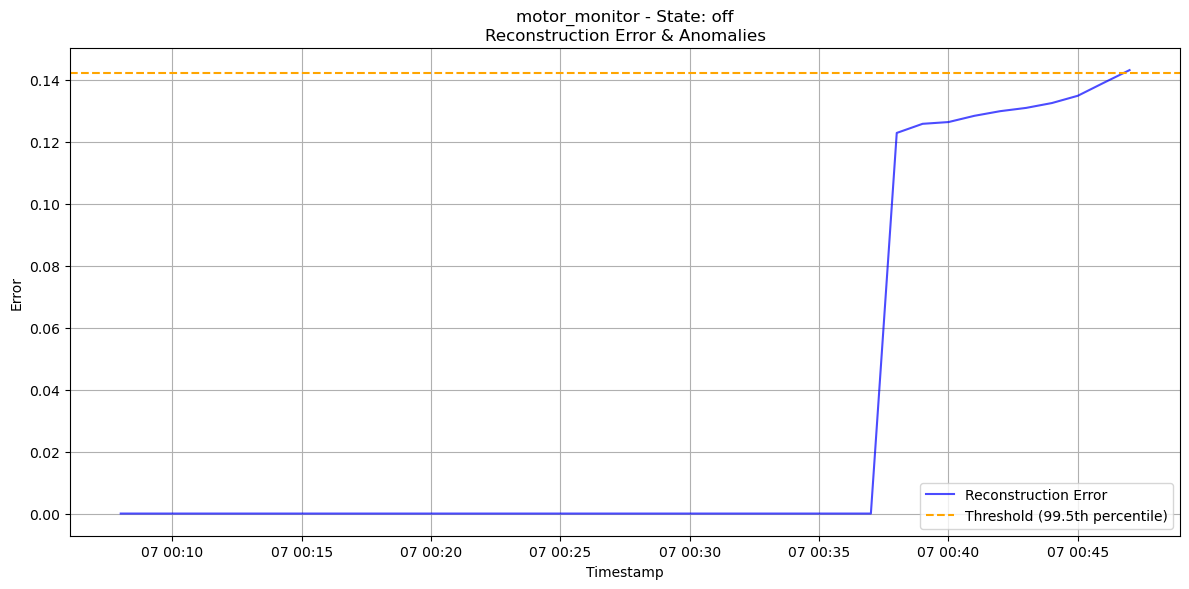

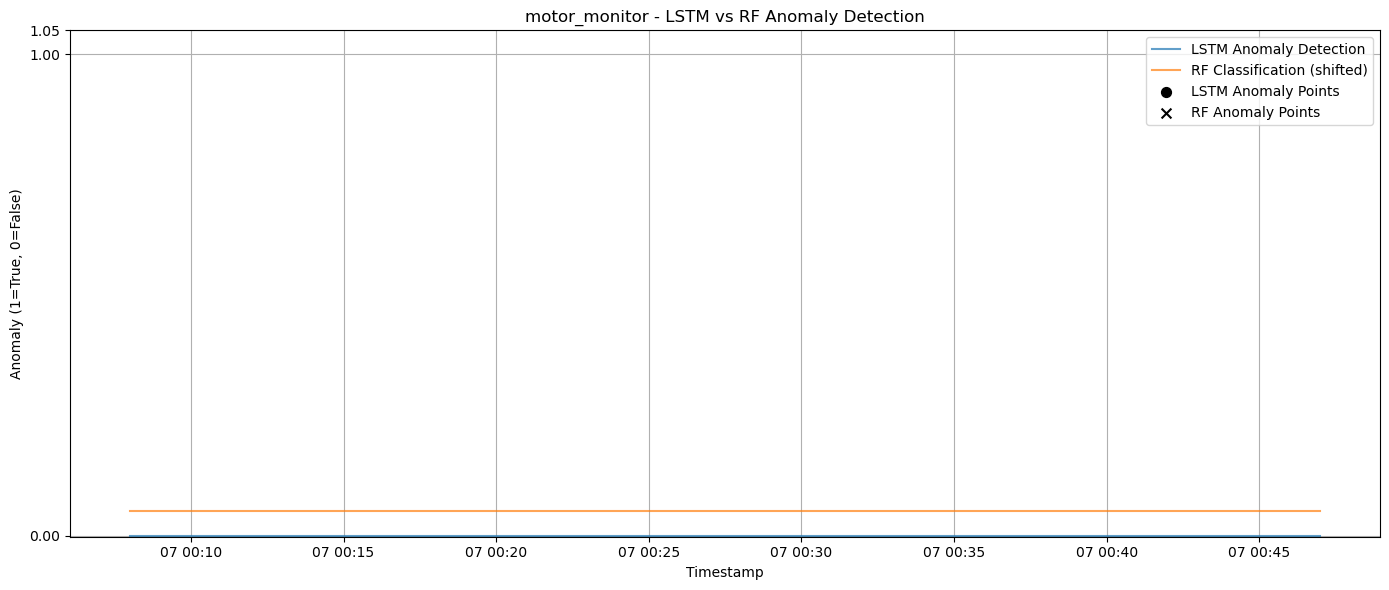

✅ Finished motor_monitor in 0.52 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:08:00   off  Normal       False  2.631539  2.616964   
1  2025-04-07 00:09:00   off  Normal       False  2.298811  2.824533   
2  2025-04-07 00:10:00   off  Normal       False  2.451170  2.820477   
3  2025-04-07 00:11:00   off  Normal       False  2.588191  2.695375   
4  2025-04-07 00:12:00   off  Normal       False  2.659420  2.182102   
5  2025-04-07 00:13:00   off  Normal       False  2.407113  2.313871   
6  2025-04-07 00:14:00   off  Normal       False  2.843730  2.769565   
7  2025-04-07 00:15:00   off  Normal       False  2.403367  2.770919   
8  2025-04-07 00:16:00   off  Normal       False  2.335112  2.218192   
9  2025-04-07 00:17:00   off  Normal       False  2.606865  2.475453   
10 2025-04-07 00:18:00   off  Normal       False  2.867416  2.449642   
11 2025-04-07 00:19:00   off  Normal       False  2.783209  2.982868   
12 2025

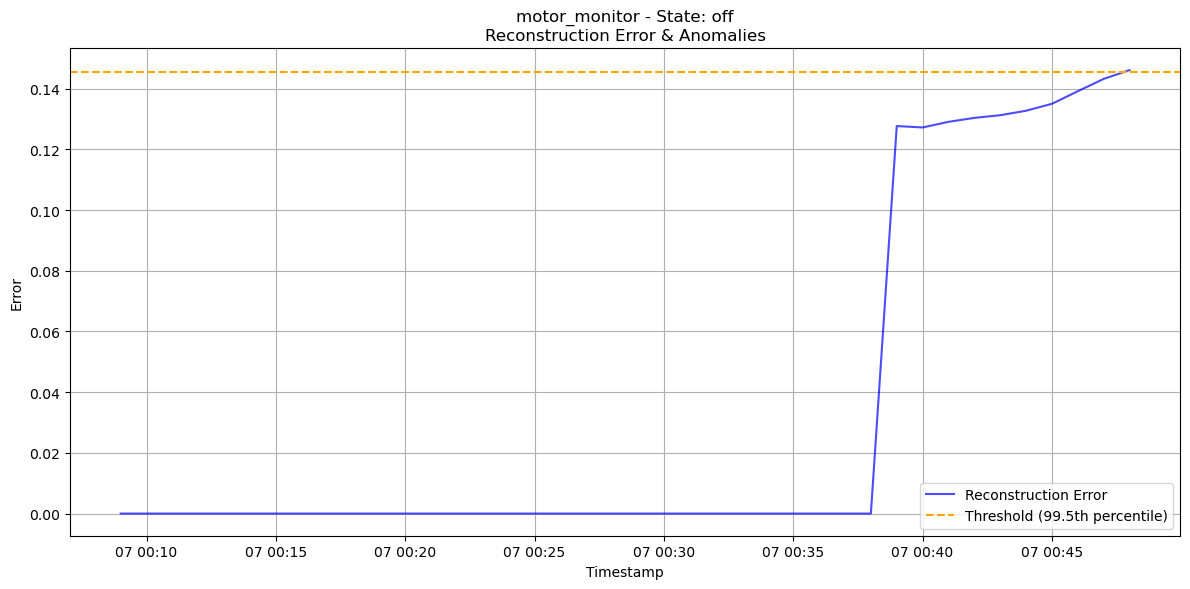

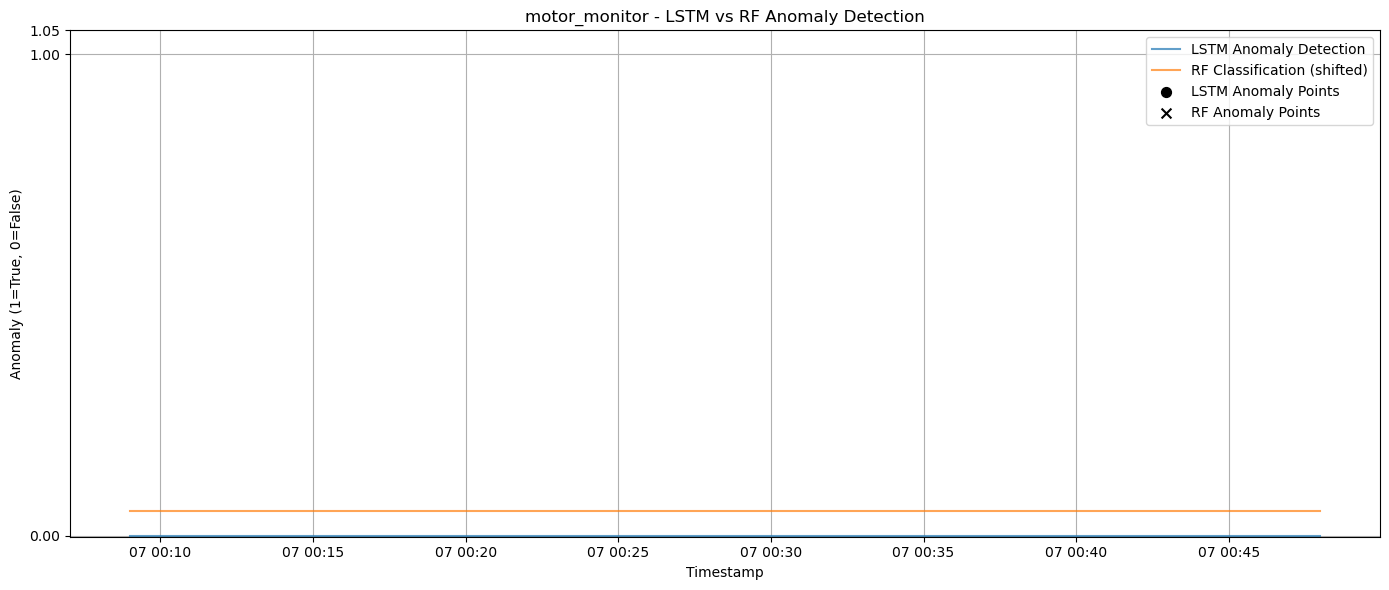

✅ Finished motor_monitor in 0.52 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:09:00   off  Normal       False  2.298811  2.824533   
1  2025-04-07 00:10:00   off  Normal       False  2.451170  2.820477   
2  2025-04-07 00:11:00   off  Normal       False  2.588191  2.695375   
3  2025-04-07 00:12:00   off  Normal       False  2.659420  2.182102   
4  2025-04-07 00:13:00   off  Normal       False  2.407113  2.313871   
5  2025-04-07 00:14:00   off  Normal       False  2.843730  2.769565   
6  2025-04-07 00:15:00   off  Normal       False  2.403367  2.770919   
7  2025-04-07 00:16:00   off  Normal       False  2.335112  2.218192   
8  2025-04-07 00:17:00   off  Normal       False  2.606865  2.475453   
9  2025-04-07 00:18:00   off  Normal       False  2.867416  2.449642   
10 2025-04-07 00:19:00   off  Normal       False  2.783209  2.982868   
11 2025-04-07 00:20:00   off  Normal       False  2.618311  2.567624   
12 2025

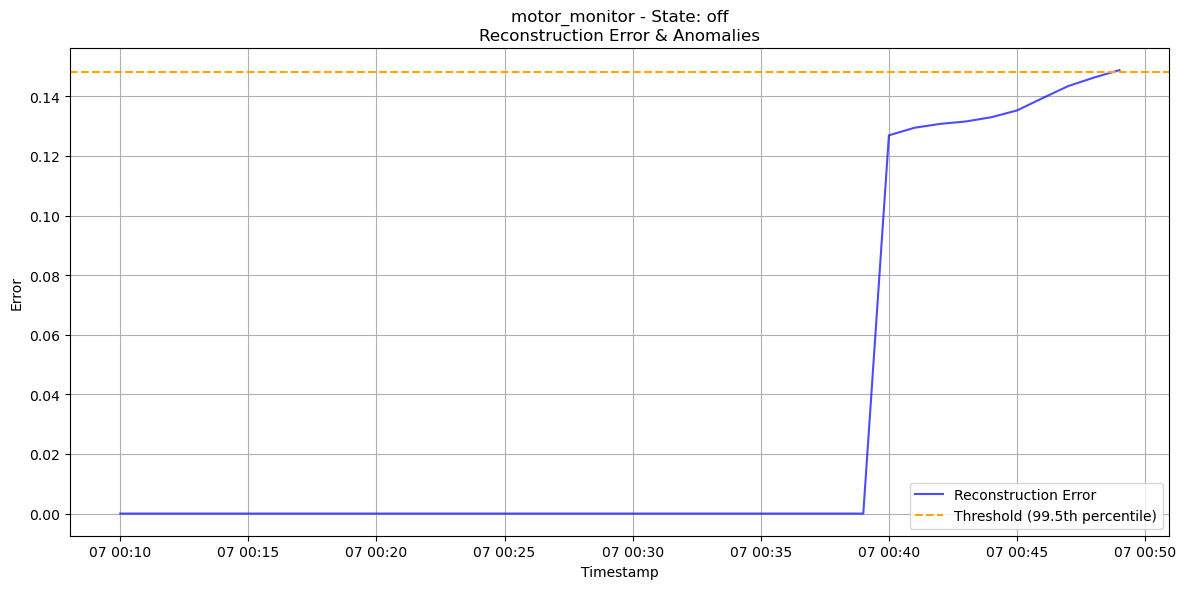

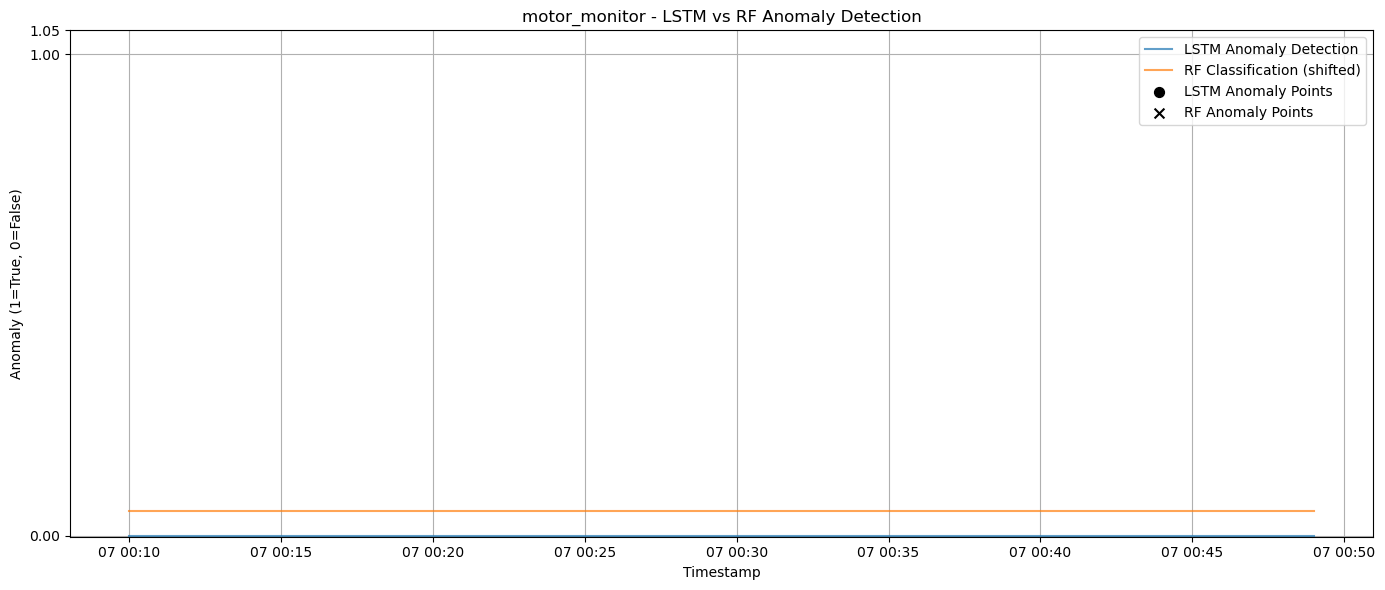

✅ Finished motor_monitor in 0.51 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:10:00   off  Normal       False  2.451170  2.820477   
1  2025-04-07 00:11:00   off  Normal       False  2.588191  2.695375   
2  2025-04-07 00:12:00   off  Normal       False  2.659420  2.182102   
3  2025-04-07 00:13:00   off  Normal       False  2.407113  2.313871   
4  2025-04-07 00:14:00   off  Normal       False  2.843730  2.769565   
5  2025-04-07 00:15:00   off  Normal       False  2.403367  2.770919   
6  2025-04-07 00:16:00   off  Normal       False  2.335112  2.218192   
7  2025-04-07 00:17:00   off  Normal       False  2.606865  2.475453   
8  2025-04-07 00:18:00   off  Normal       False  2.867416  2.449642   
9  2025-04-07 00:19:00   off  Normal       False  2.783209  2.982868   
10 2025-04-07 00:20:00   off  Normal       False  2.618311  2.567624   
11 2025-04-07 00:21:00   off  Normal       False  2.854161  2.940613   
12 2025

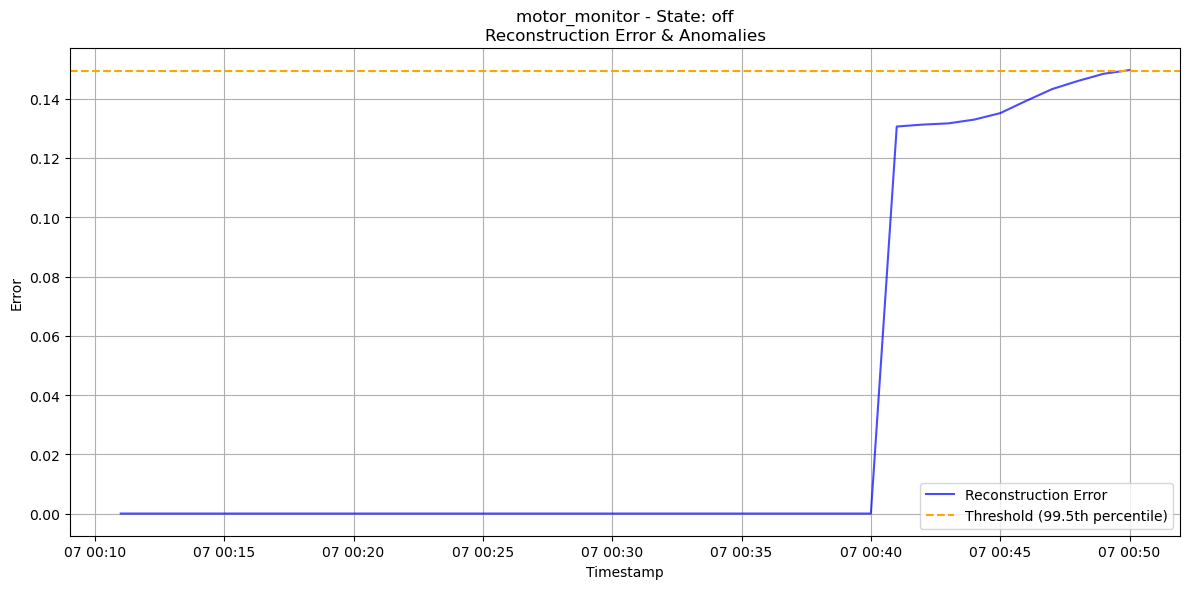

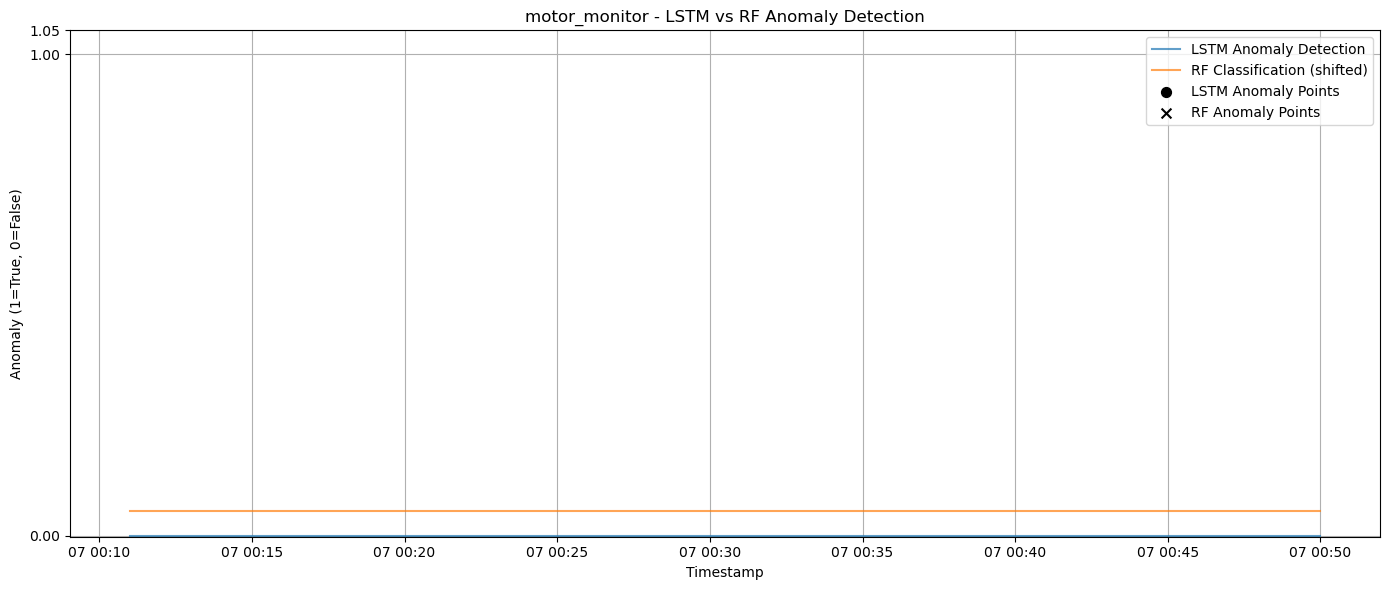

✅ Finished motor_monitor in 0.52 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:11:00   off  Normal       False  2.588191  2.695375   
1  2025-04-07 00:12:00   off  Normal       False  2.659420  2.182102   
2  2025-04-07 00:13:00   off  Normal       False  2.407113  2.313871   
3  2025-04-07 00:14:00   off  Normal       False  2.843730  2.769565   
4  2025-04-07 00:15:00   off  Normal       False  2.403367  2.770919   
5  2025-04-07 00:16:00   off  Normal       False  2.335112  2.218192   
6  2025-04-07 00:17:00   off  Normal       False  2.606865  2.475453   
7  2025-04-07 00:18:00   off  Normal       False  2.867416  2.449642   
8  2025-04-07 00:19:00   off  Normal       False  2.783209  2.982868   
9  2025-04-07 00:20:00   off  Normal       False  2.618311  2.567624   
10 2025-04-07 00:21:00   off  Normal       False  2.854161  2.940613   
11 2025-04-07 00:22:00   off  Normal       False  3.055437  2.630198   
12 2025

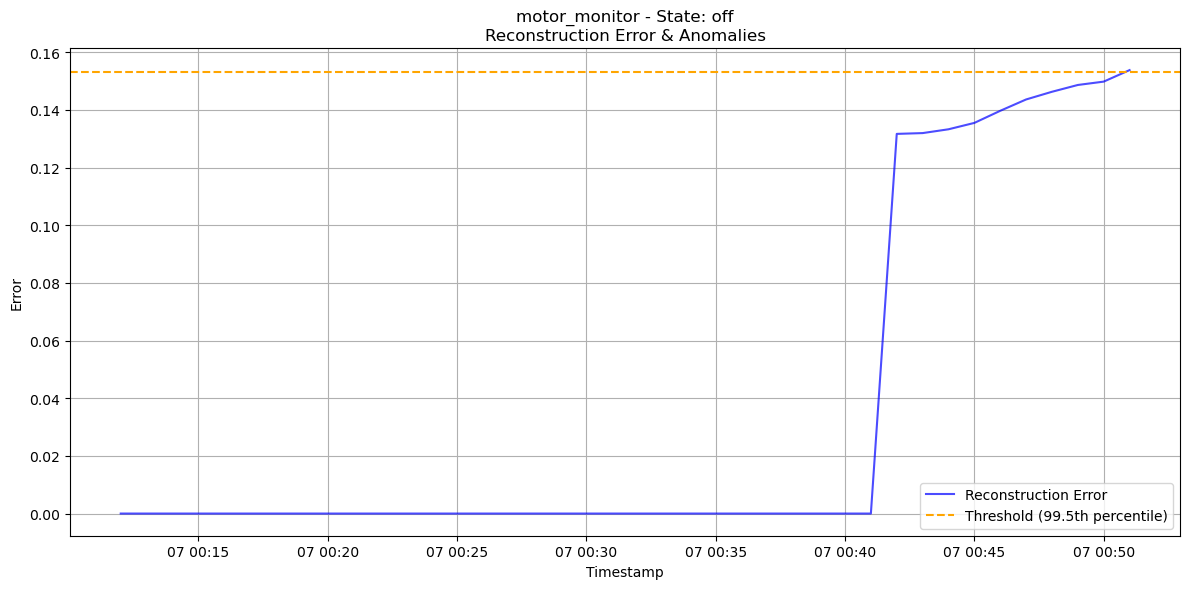

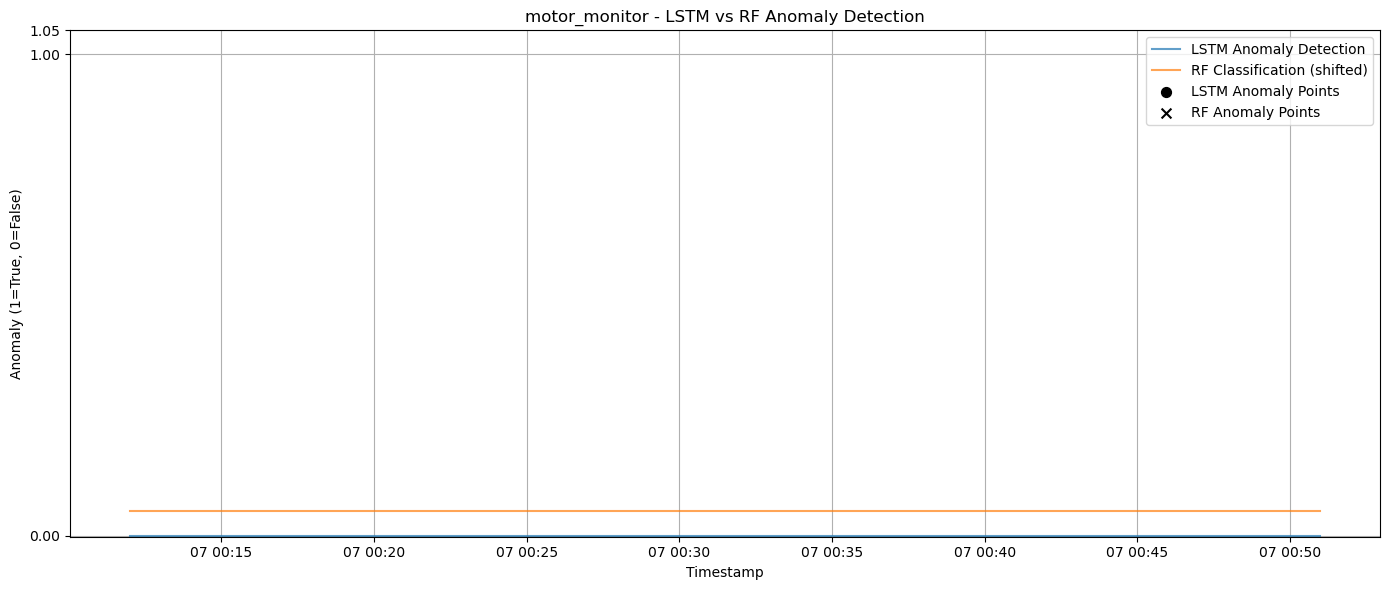

✅ Finished motor_monitor in 0.52 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:12:00   off  Normal       False  2.659420  2.182102   
1  2025-04-07 00:13:00   off  Normal       False  2.407113  2.313871   
2  2025-04-07 00:14:00   off  Normal       False  2.843730  2.769565   
3  2025-04-07 00:15:00   off  Normal       False  2.403367  2.770919   
4  2025-04-07 00:16:00   off  Normal       False  2.335112  2.218192   
5  2025-04-07 00:17:00   off  Normal       False  2.606865  2.475453   
6  2025-04-07 00:18:00   off  Normal       False  2.867416  2.449642   
7  2025-04-07 00:19:00   off  Normal       False  2.783209  2.982868   
8  2025-04-07 00:20:00   off  Normal       False  2.618311  2.567624   
9  2025-04-07 00:21:00   off  Normal       False  2.854161  2.940613   
10 2025-04-07 00:22:00   off  Normal       False  3.055437  2.630198   
11 2025-04-07 00:23:00   off  Normal       False  3.048145  2.503308   
12 2025

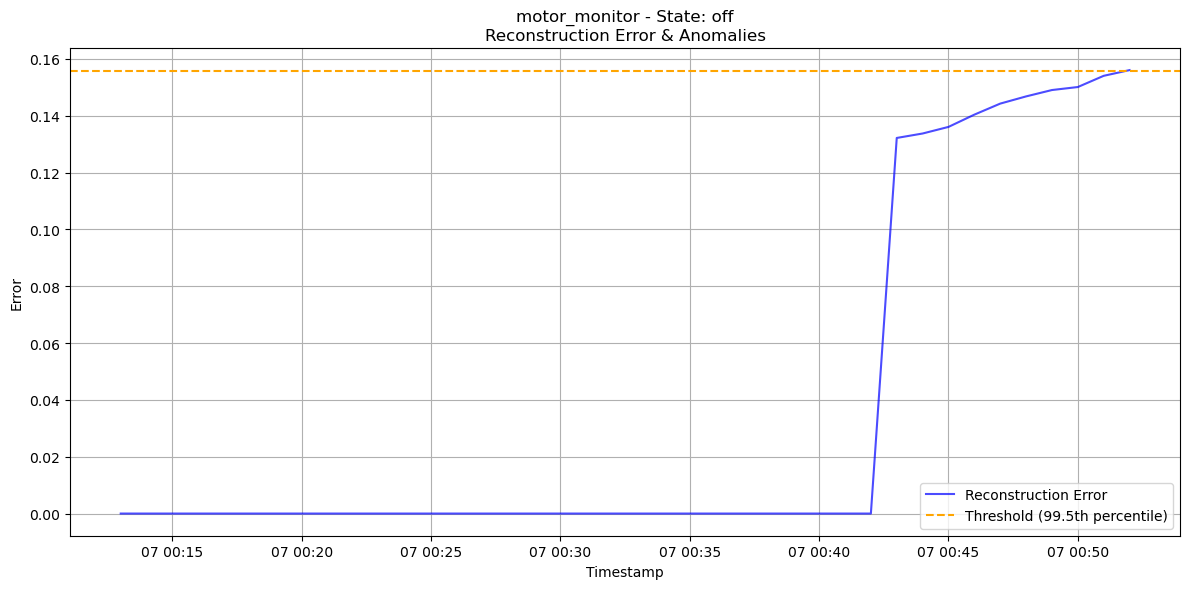

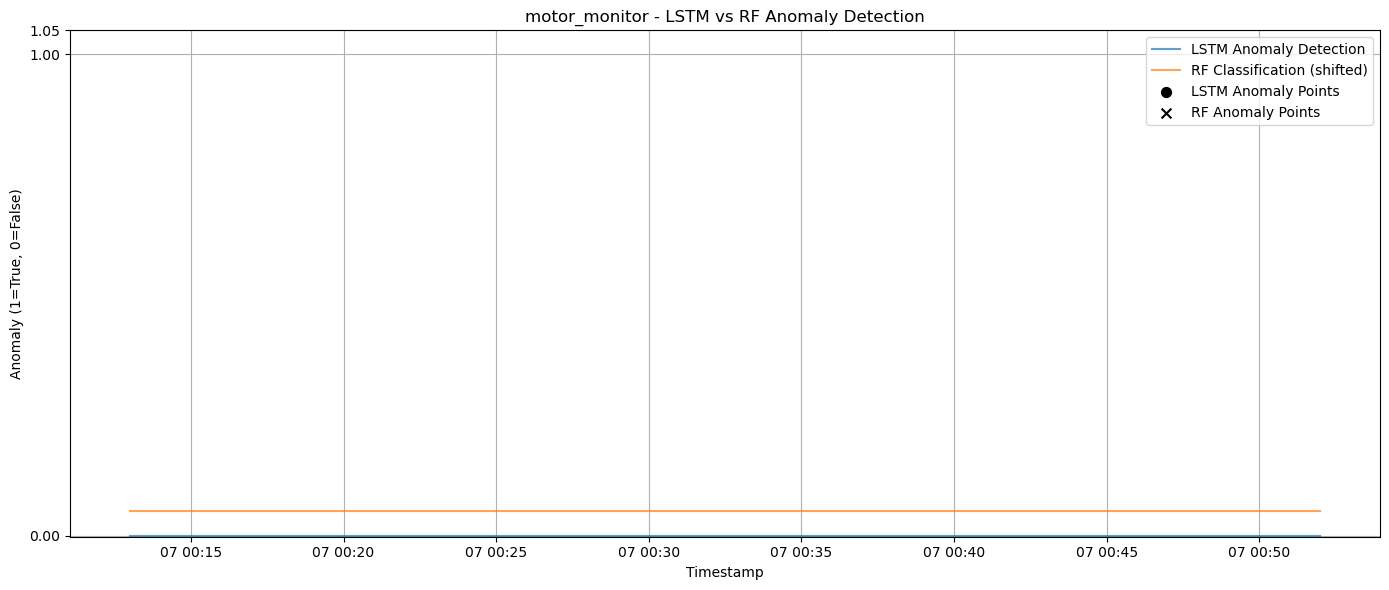

✅ Finished motor_monitor in 0.52 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:13:00   off  Normal       False  2.407113  2.313871   
1  2025-04-07 00:14:00   off  Normal       False  2.843730  2.769565   
2  2025-04-07 00:15:00   off  Normal       False  2.403367  2.770919   
3  2025-04-07 00:16:00   off  Normal       False  2.335112  2.218192   
4  2025-04-07 00:17:00   off  Normal       False  2.606865  2.475453   
5  2025-04-07 00:18:00   off  Normal       False  2.867416  2.449642   
6  2025-04-07 00:19:00   off  Normal       False  2.783209  2.982868   
7  2025-04-07 00:20:00   off  Normal       False  2.618311  2.567624   
8  2025-04-07 00:21:00   off  Normal       False  2.854161  2.940613   
9  2025-04-07 00:22:00   off  Normal       False  3.055437  2.630198   
10 2025-04-07 00:23:00   off  Normal       False  3.048145  2.503308   
11 2025-04-07 00:24:00   off  Normal       False  3.048236  2.457059   
12 2025

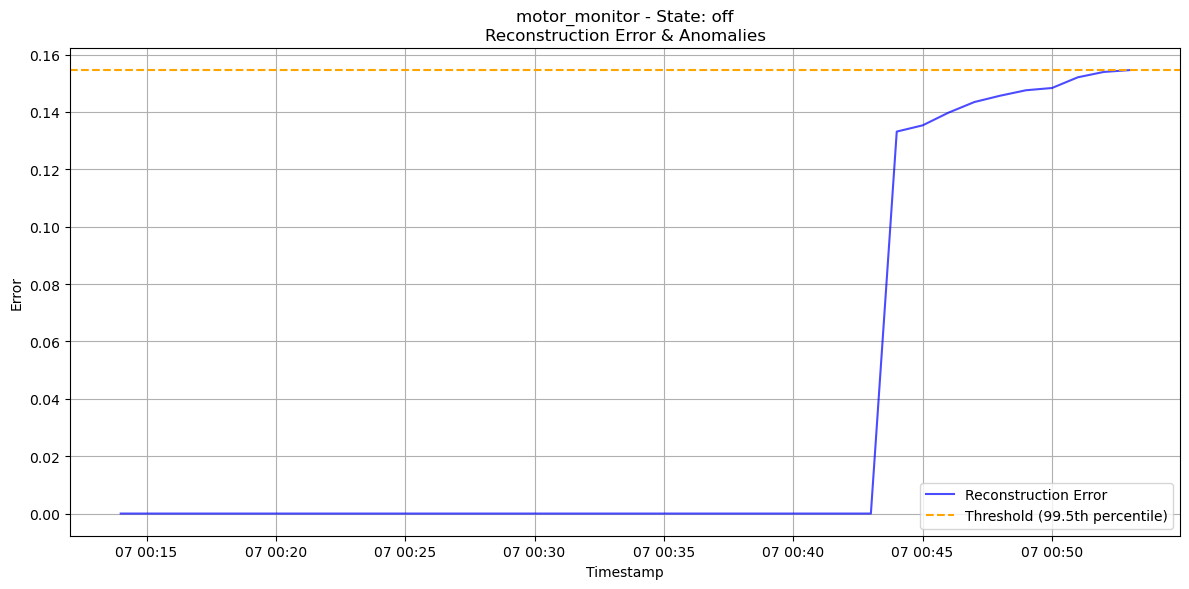

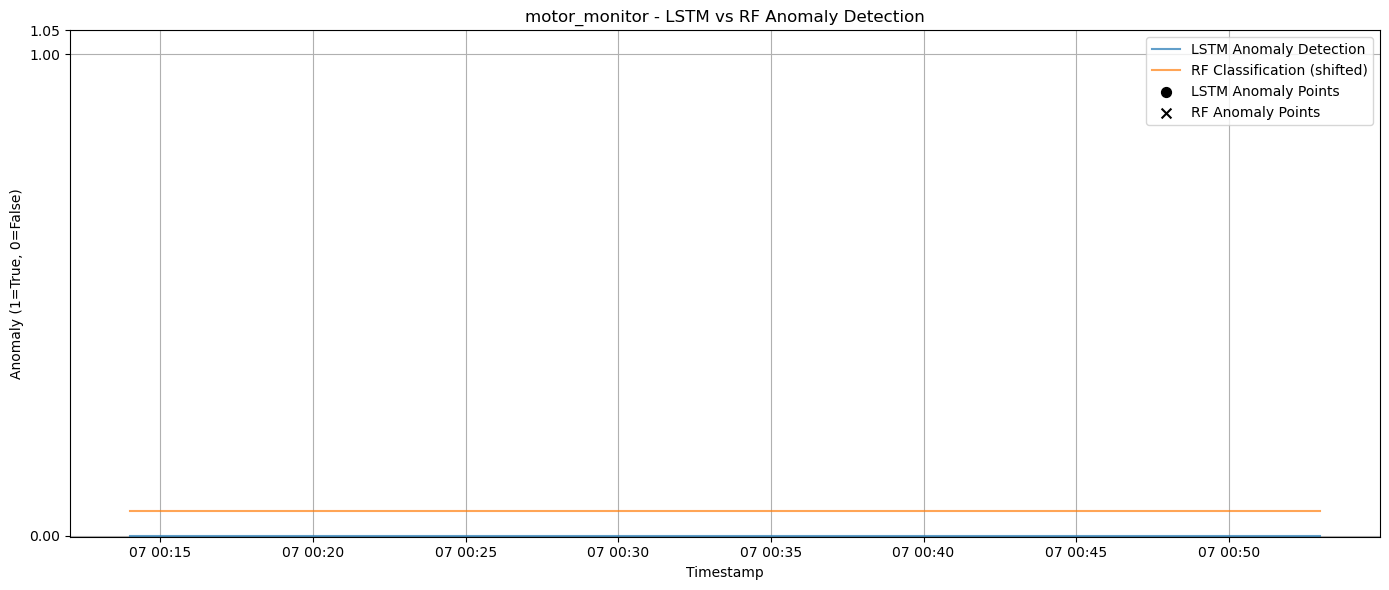

✅ Finished motor_monitor in 0.51 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:14:00   off  Normal       False  2.843730  2.769565   
1  2025-04-07 00:15:00   off  Normal       False  2.403367  2.770919   
2  2025-04-07 00:16:00   off  Normal       False  2.335112  2.218192   
3  2025-04-07 00:17:00   off  Normal       False  2.606865  2.475453   
4  2025-04-07 00:18:00   off  Normal       False  2.867416  2.449642   
5  2025-04-07 00:19:00   off  Normal       False  2.783209  2.982868   
6  2025-04-07 00:20:00   off  Normal       False  2.618311  2.567624   
7  2025-04-07 00:21:00   off  Normal       False  2.854161  2.940613   
8  2025-04-07 00:22:00   off  Normal       False  3.055437  2.630198   
9  2025-04-07 00:23:00   off  Normal       False  3.048145  2.503308   
10 2025-04-07 00:24:00   off  Normal       False  3.048236  2.457059   
11 2025-04-07 00:25:00   off  Normal       False  2.481396  2.919085   
12 2025

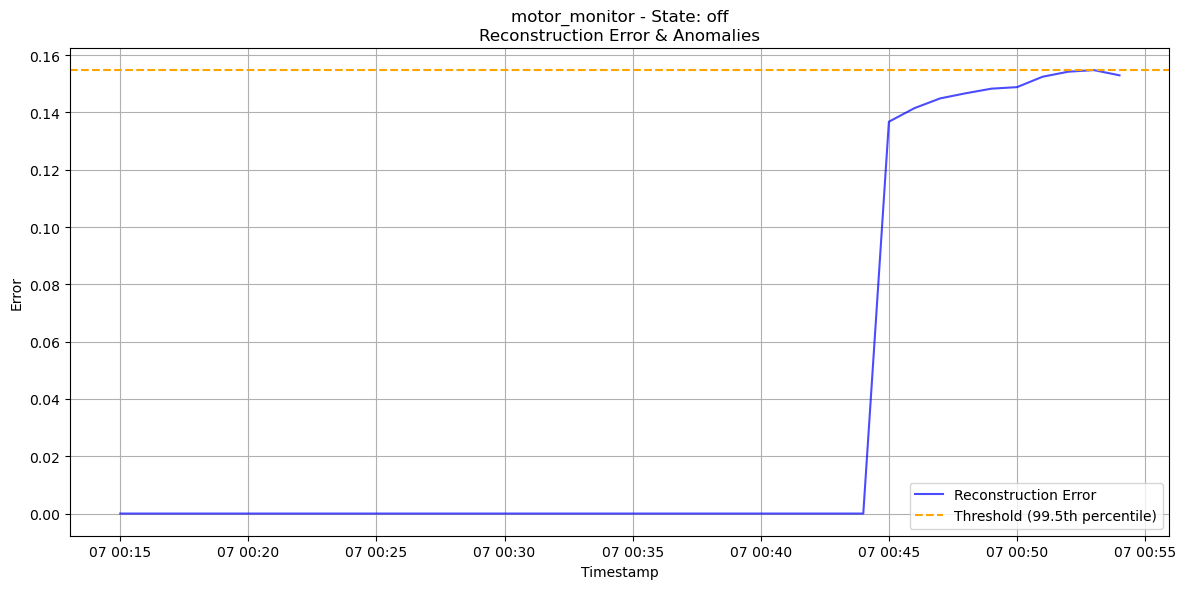

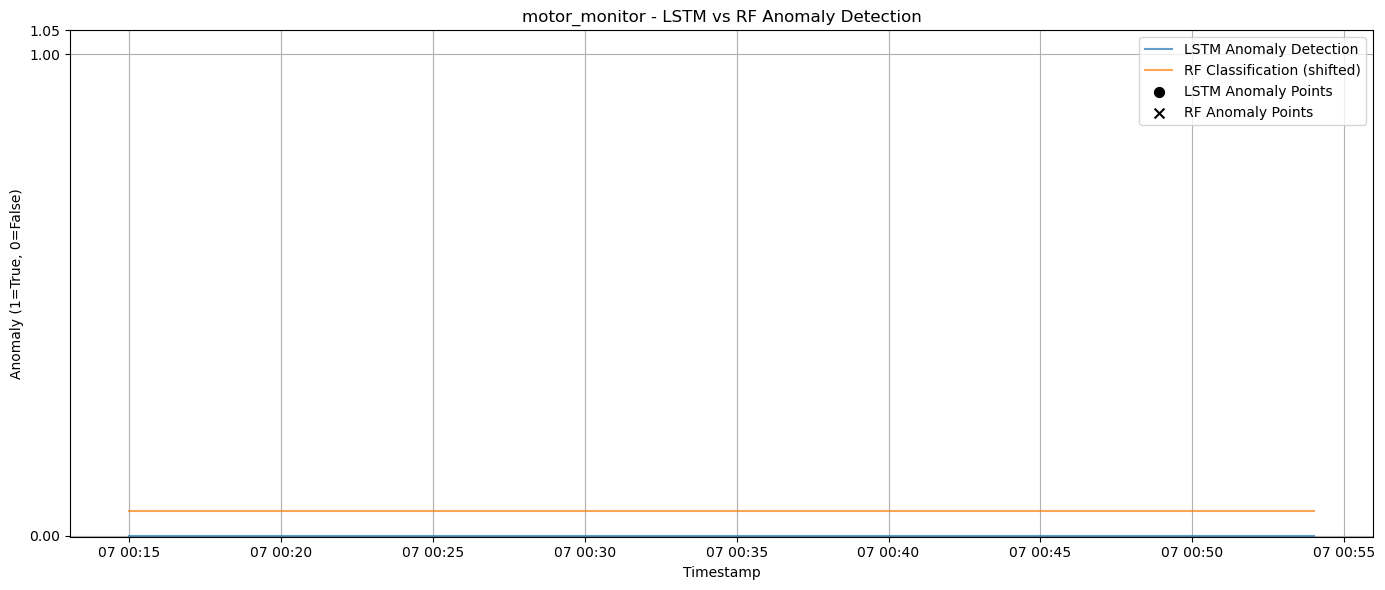

✅ Finished motor_monitor in 0.97 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:15:00   off  Normal       False  2.403367  2.770919   
1  2025-04-07 00:16:00   off  Normal       False  2.335112  2.218192   
2  2025-04-07 00:17:00   off  Normal       False  2.606865  2.475453   
3  2025-04-07 00:18:00   off  Normal       False  2.867416  2.449642   
4  2025-04-07 00:19:00   off  Normal       False  2.783209  2.982868   
5  2025-04-07 00:20:00   off  Normal       False  2.618311  2.567624   
6  2025-04-07 00:21:00   off  Normal       False  2.854161  2.940613   
7  2025-04-07 00:22:00   off  Normal       False  3.055437  2.630198   
8  2025-04-07 00:23:00   off  Normal       False  3.048145  2.503308   
9  2025-04-07 00:24:00   off  Normal       False  3.048236  2.457059   
10 2025-04-07 00:25:00   off  Normal       False  2.481396  2.919085   
11 2025-04-07 00:26:00   off  Normal       False  2.613110  2.735317   
12 2025

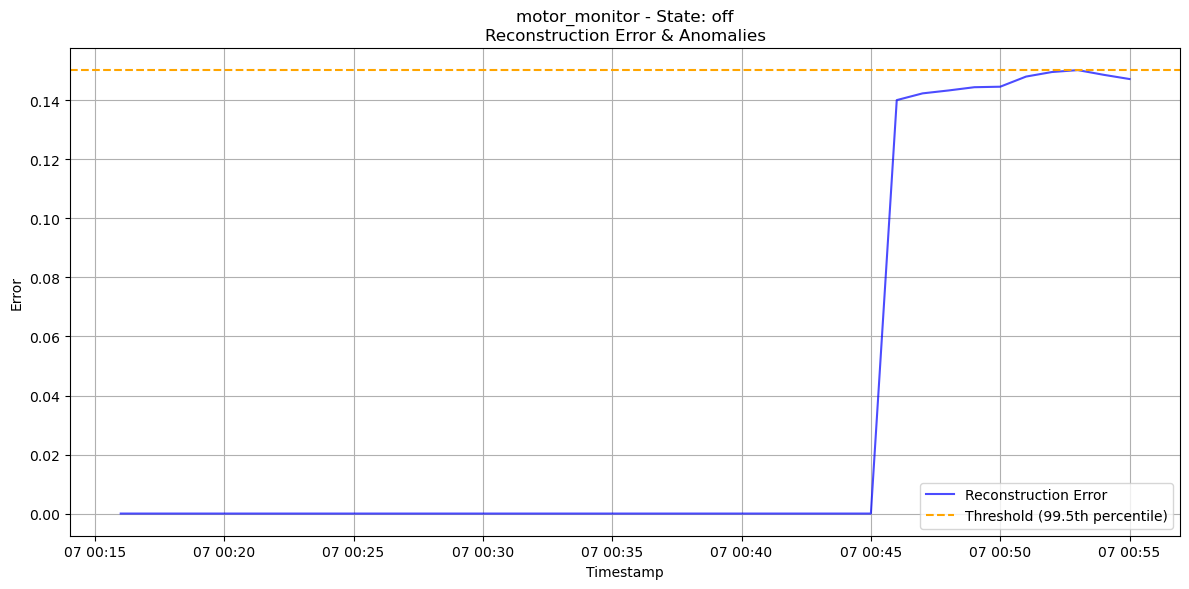

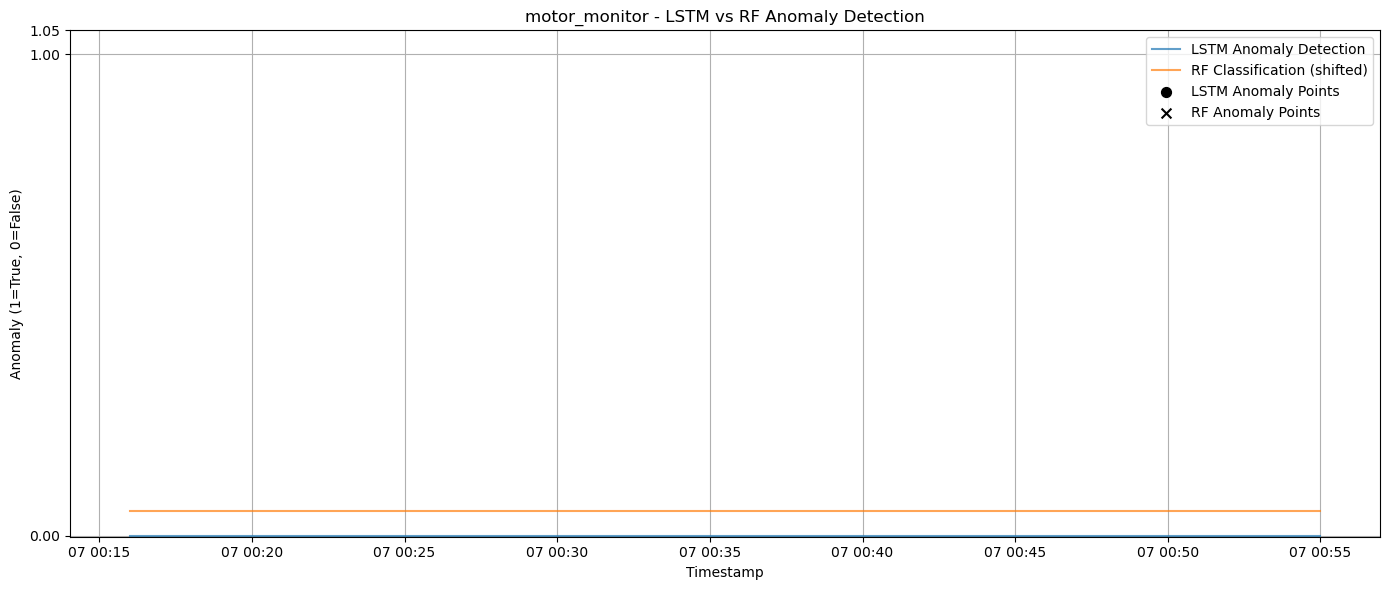

✅ Finished motor_monitor in 0.53 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:16:00   off  Normal       False  2.335112  2.218192   
1  2025-04-07 00:17:00   off  Normal       False  2.606865  2.475453   
2  2025-04-07 00:18:00   off  Normal       False  2.867416  2.449642   
3  2025-04-07 00:19:00   off  Normal       False  2.783209  2.982868   
4  2025-04-07 00:20:00   off  Normal       False  2.618311  2.567624   
5  2025-04-07 00:21:00   off  Normal       False  2.854161  2.940613   
6  2025-04-07 00:22:00   off  Normal       False  3.055437  2.630198   
7  2025-04-07 00:23:00   off  Normal       False  3.048145  2.503308   
8  2025-04-07 00:24:00   off  Normal       False  3.048236  2.457059   
9  2025-04-07 00:25:00   off  Normal       False  2.481396  2.919085   
10 2025-04-07 00:26:00   off  Normal       False  2.613110  2.735317   
11 2025-04-07 00:27:00   off  Normal       False  2.415534  2.813989   
12 2025

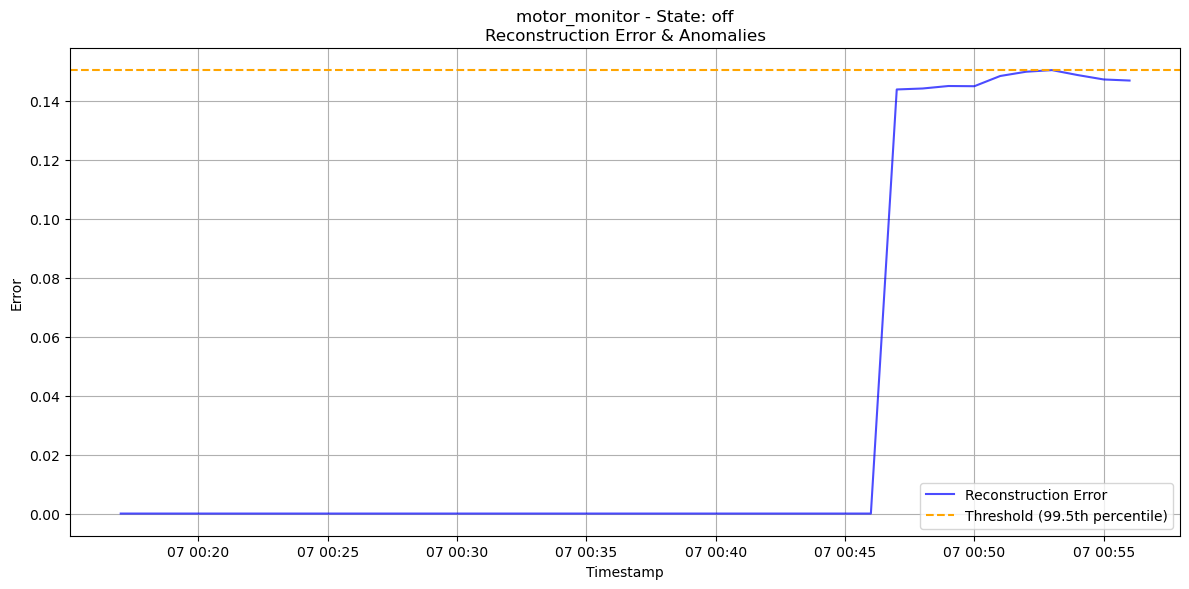

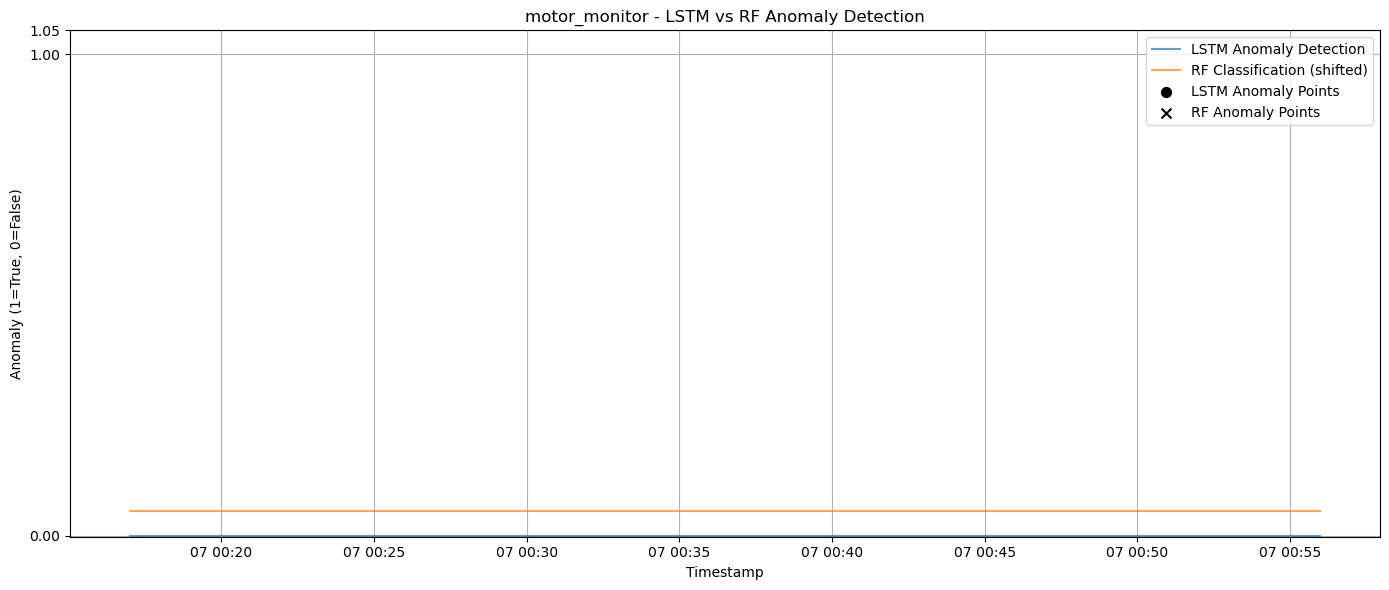

✅ Finished motor_monitor in 0.54 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:17:00   off  Normal       False  2.606865  2.475453   
1  2025-04-07 00:18:00   off  Normal       False  2.867416  2.449642   
2  2025-04-07 00:19:00   off  Normal       False  2.783209  2.982868   
3  2025-04-07 00:20:00   off  Normal       False  2.618311  2.567624   
4  2025-04-07 00:21:00   off  Normal       False  2.854161  2.940613   
5  2025-04-07 00:22:00   off  Normal       False  3.055437  2.630198   
6  2025-04-07 00:23:00   off  Normal       False  3.048145  2.503308   
7  2025-04-07 00:24:00   off  Normal       False  3.048236  2.457059   
8  2025-04-07 00:25:00   off  Normal       False  2.481396  2.919085   
9  2025-04-07 00:26:00   off  Normal       False  2.613110  2.735317   
10 2025-04-07 00:27:00   off  Normal       False  2.415534  2.813989   
11 2025-04-07 00:28:00   off  Normal       False  2.414530  2.569097   
12 2025

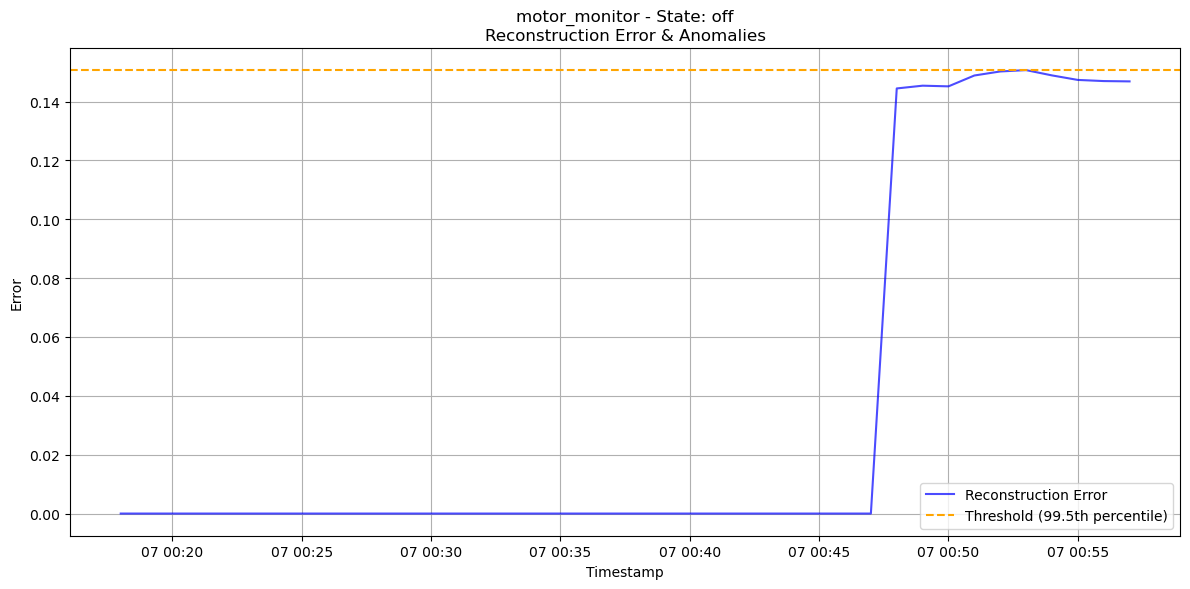

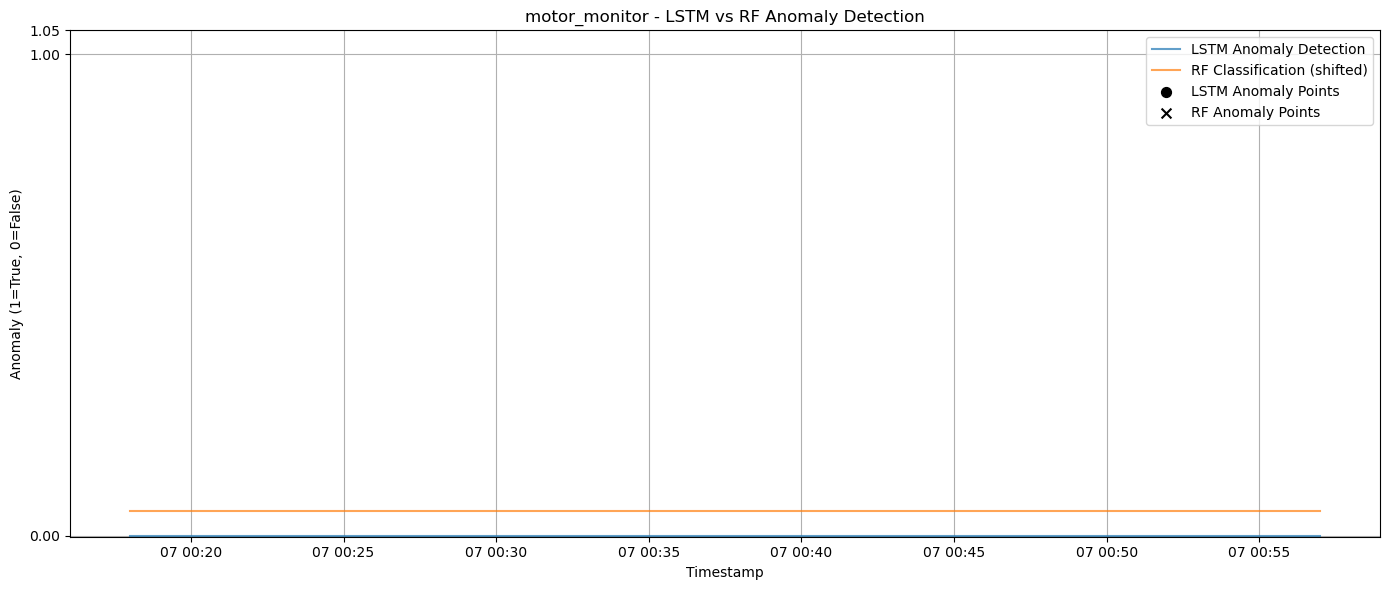

✅ Finished motor_monitor in 0.52 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:18:00   off  Normal       False  2.867416  2.449642   
1  2025-04-07 00:19:00   off  Normal       False  2.783209  2.982868   
2  2025-04-07 00:20:00   off  Normal       False  2.618311  2.567624   
3  2025-04-07 00:21:00   off  Normal       False  2.854161  2.940613   
4  2025-04-07 00:22:00   off  Normal       False  3.055437  2.630198   
5  2025-04-07 00:23:00   off  Normal       False  3.048145  2.503308   
6  2025-04-07 00:24:00   off  Normal       False  3.048236  2.457059   
7  2025-04-07 00:25:00   off  Normal       False  2.481396  2.919085   
8  2025-04-07 00:26:00   off  Normal       False  2.613110  2.735317   
9  2025-04-07 00:27:00   off  Normal       False  2.415534  2.813989   
10 2025-04-07 00:28:00   off  Normal       False  2.414530  2.569097   
11 2025-04-07 00:29:00   off  Normal       False  2.730771  2.327055   
12 2025

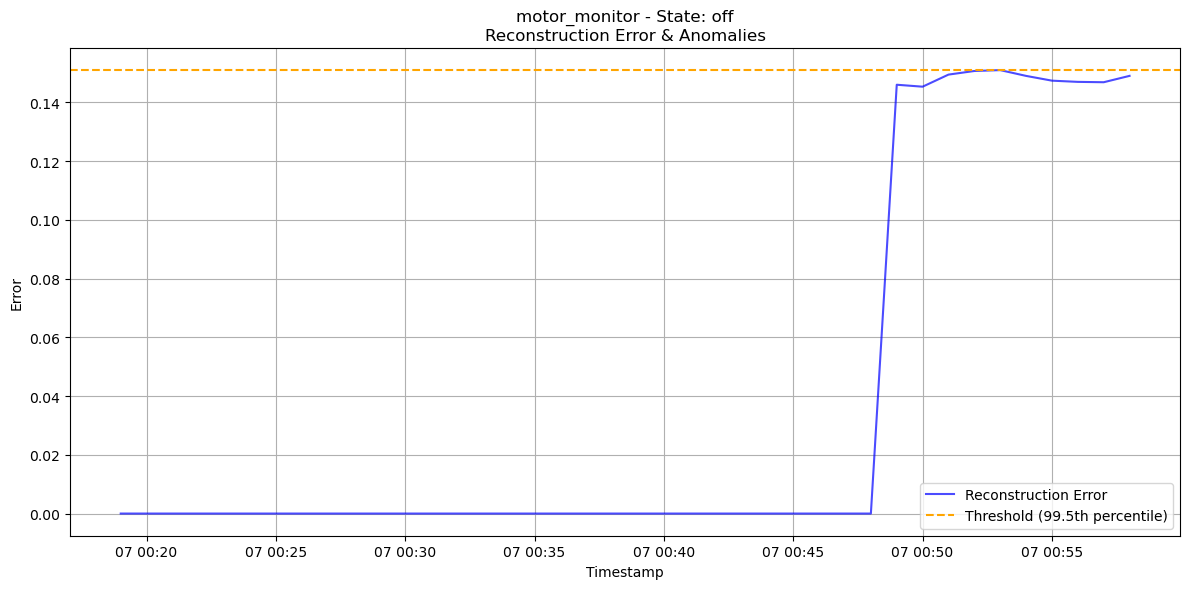

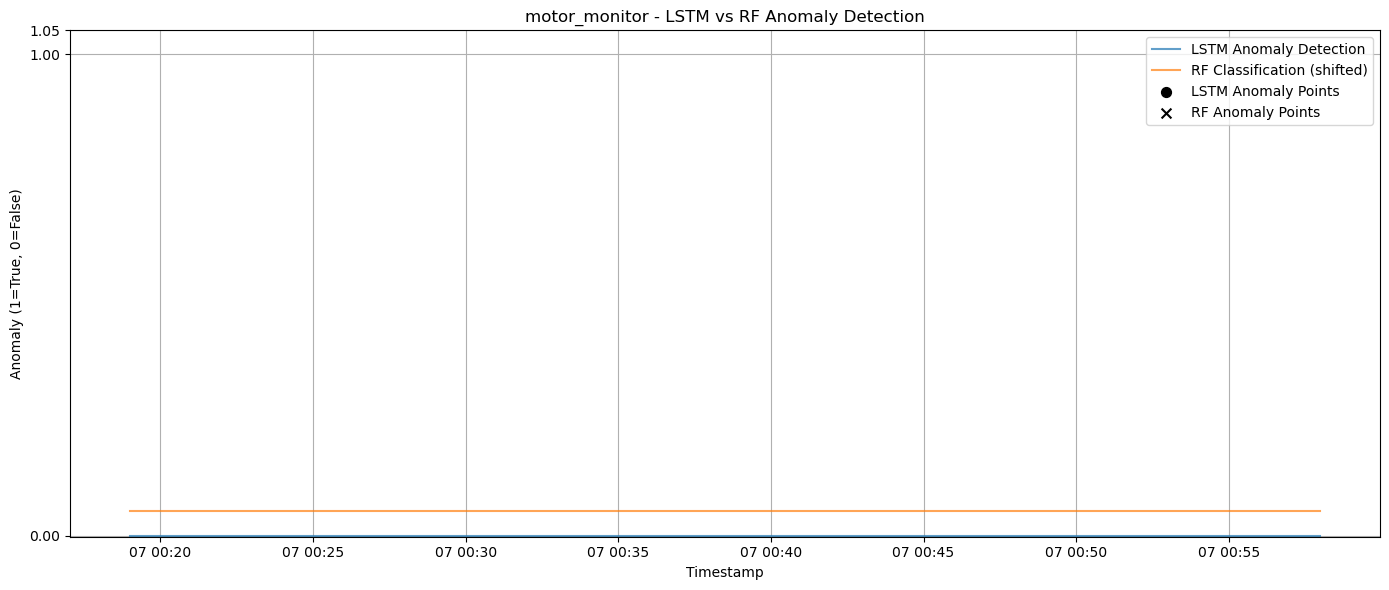

✅ Finished motor_monitor in 0.52 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:19:00   off  Normal       False  2.783209  2.982868   
1  2025-04-07 00:20:00   off  Normal       False  2.618311  2.567624   
2  2025-04-07 00:21:00   off  Normal       False  2.854161  2.940613   
3  2025-04-07 00:22:00   off  Normal       False  3.055437  2.630198   
4  2025-04-07 00:23:00   off  Normal       False  3.048145  2.503308   
5  2025-04-07 00:24:00   off  Normal       False  3.048236  2.457059   
6  2025-04-07 00:25:00   off  Normal       False  2.481396  2.919085   
7  2025-04-07 00:26:00   off  Normal       False  2.613110  2.735317   
8  2025-04-07 00:27:00   off  Normal       False  2.415534  2.813989   
9  2025-04-07 00:28:00   off  Normal       False  2.414530  2.569097   
10 2025-04-07 00:29:00   off  Normal       False  2.730771  2.327055   
11 2025-04-07 00:30:00   off  Normal       False  2.837282  2.524602   
12 2025

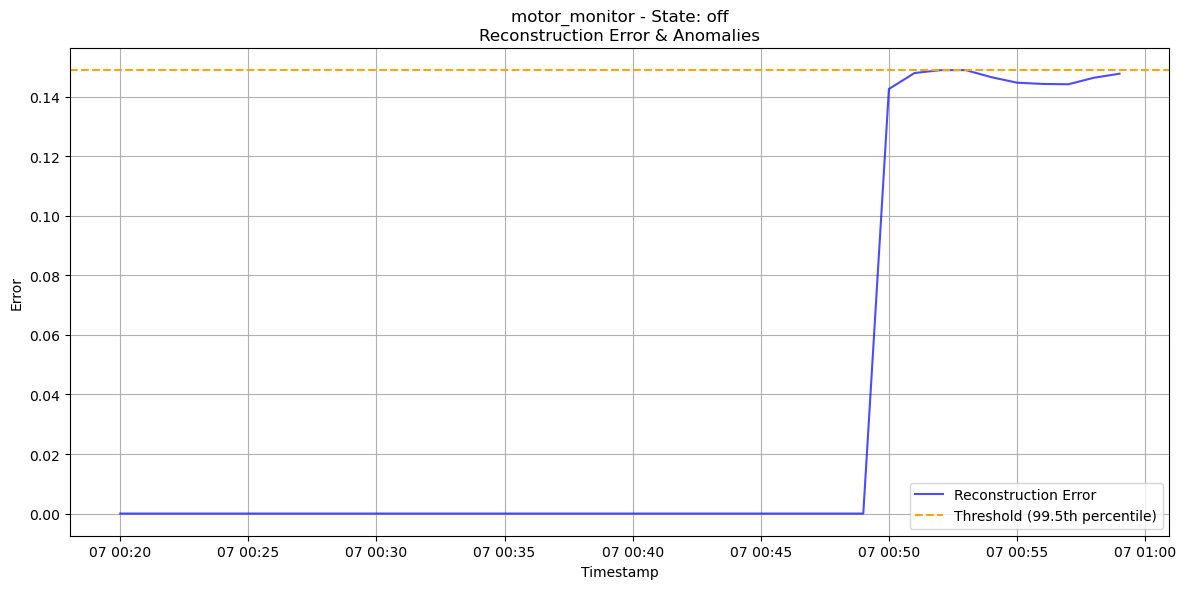

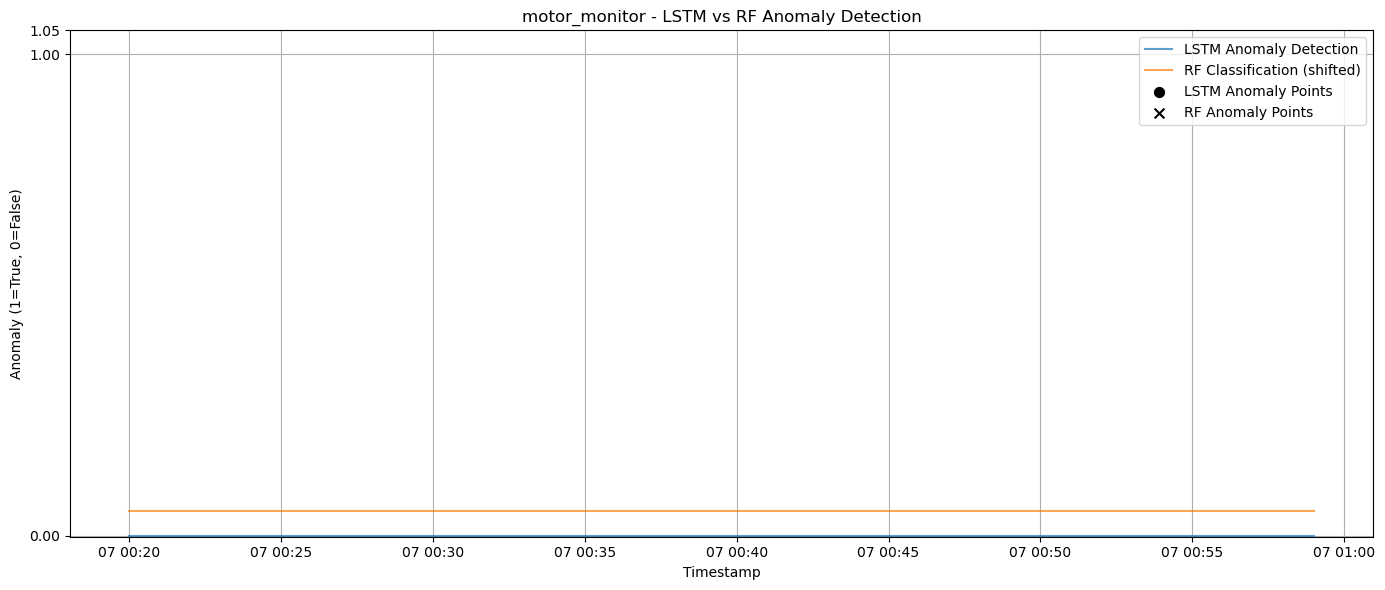

✅ Finished motor_monitor in 0.54 sec
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:20:00   off  Normal       False  2.618311  2.567624   
1  2025-04-07 00:21:00   off  Normal       False  2.854161  2.940613   
2  2025-04-07 00:22:00   off  Normal       False  3.055437  2.630198   
3  2025-04-07 00:23:00   off  Normal       False  3.048145  2.503308   
4  2025-04-07 00:24:00   off  Normal       False  3.048236  2.457059   
5  2025-04-07 00:25:00   off  Normal       False  2.481396  2.919085   
6  2025-04-07 00:26:00   off  Normal       False  2.613110  2.735317   
7  2025-04-07 00:27:00   off  Normal       False  2.415534  2.813989   
8  2025-04-07 00:28:00   off  Normal       False  2.414530  2.569097   
9  2025-04-07 00:29:00   off  Normal       False  2.730771  2.327055   
10 2025-04-07 00:30:00   off  Normal       False  2.837282  2.524602   
11 2025-04-07 00:31:00   off  Normal       False  2.649856  2.755493   
12 2025

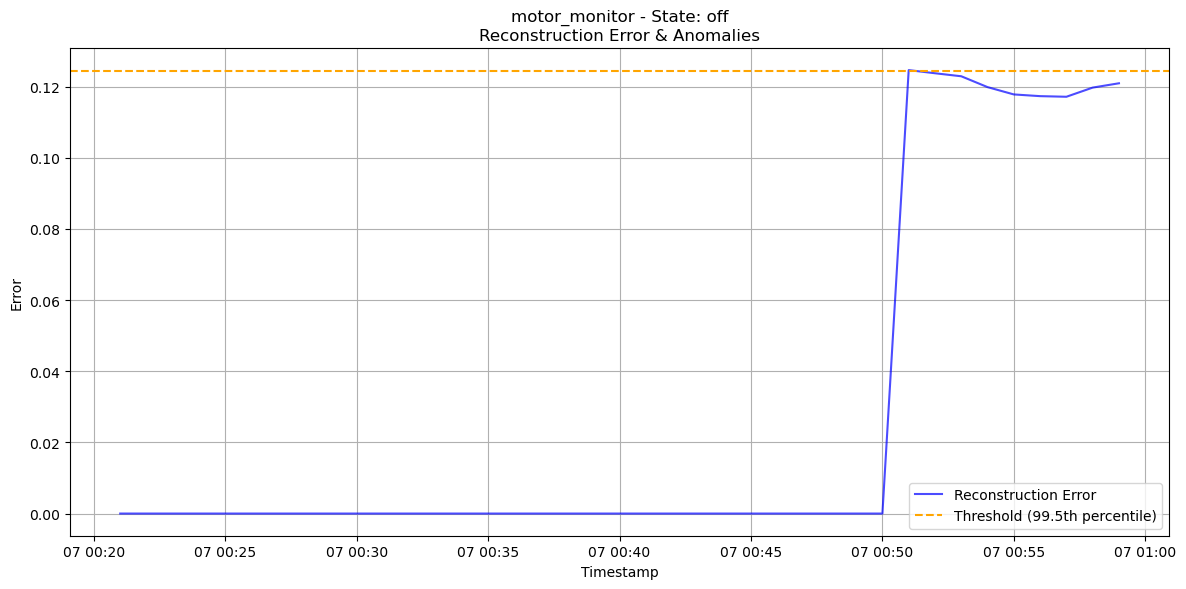

❌ Error processing motor_monitor: cannot access local variable 'batch_outputs' where it is not associated with a value
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:21:00   off  Normal       False  2.854161  2.940613   
1  2025-04-07 00:22:00   off  Normal       False  3.055437  2.630198   
2  2025-04-07 00:23:00   off  Normal       False  3.048145  2.503308   
3  2025-04-07 00:24:00   off  Normal       False  3.048236  2.457059   
4  2025-04-07 00:25:00   off  Normal       False  2.481396  2.919085   
5  2025-04-07 00:26:00   off  Normal       False  2.613110  2.735317   
6  2025-04-07 00:27:00   off  Normal       False  2.415534  2.813989   
7  2025-04-07 00:28:00   off  Normal       False  2.414530  2.569097   
8  2025-04-07 00:29:00   off  Normal       False  2.730771  2.327055   
9  2025-04-07 00:30:00   off  Normal       False  2.837282  2.524602   
10 2025-04-07 00:31:00   off  Normal       False  2.649856  2.755493 

g:\Conda\envs\python3.12\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Processing MQTT data for device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']
Threshold for g:\ABMT\anomaly-detection\src\pipeline\../../storage/saved_models/lstm_off.h5: 0.123142 (99.5th percentile)


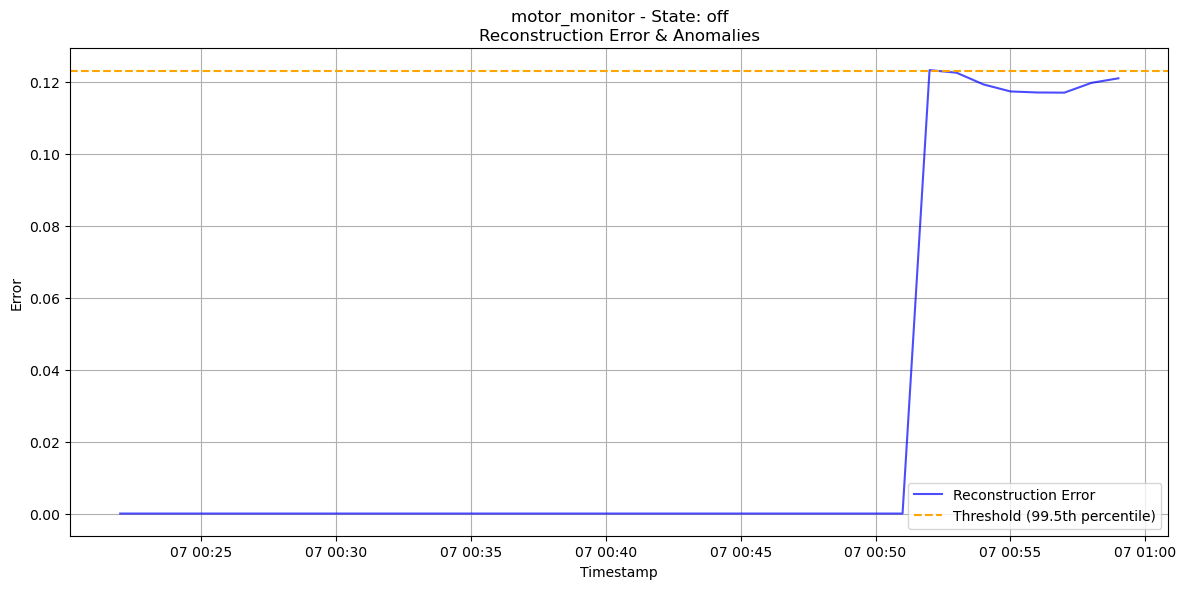

❌ Error processing motor_monitor: cannot access local variable 'batch_outputs' where it is not associated with a value
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:22:00   off  Normal       False  3.055437  2.630198   
1  2025-04-07 00:23:00   off  Normal       False  3.048145  2.503308   
2  2025-04-07 00:24:00   off  Normal       False  3.048236  2.457059   
3  2025-04-07 00:25:00   off  Normal       False  2.481396  2.919085   
4  2025-04-07 00:26:00   off  Normal       False  2.613110  2.735317   
5  2025-04-07 00:27:00   off  Normal       False  2.415534  2.813989   
6  2025-04-07 00:28:00   off  Normal       False  2.414530  2.569097   
7  2025-04-07 00:29:00   off  Normal       False  2.730771  2.327055   
8  2025-04-07 00:30:00   off  Normal       False  2.837282  2.524602   
9  2025-04-07 00:31:00   off  Normal       False  2.649856  2.755493   
10 2025-04-07 00:32:00   off  Normal       False  2.633452  2.905707 

g:\Conda\envs\python3.12\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Processing MQTT data for device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']
Threshold for g:\ABMT\anomaly-detection\src\pipeline\../../storage/saved_models/lstm_off.h5: 0.121932 (99.5th percentile)


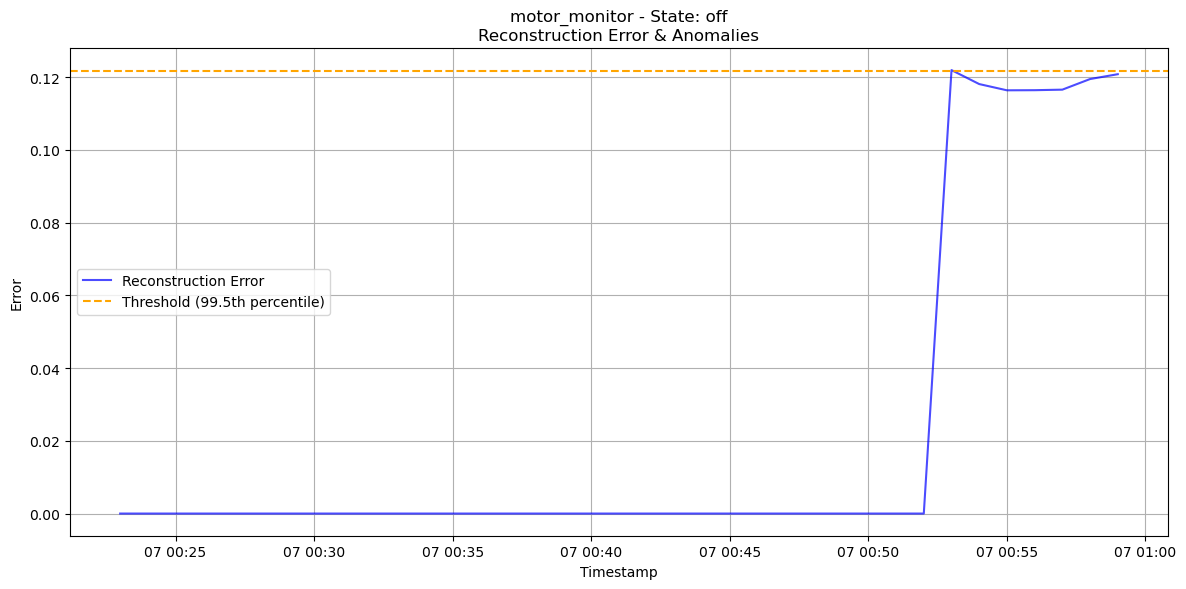

❌ Error processing motor_monitor: cannot access local variable 'batch_outputs' where it is not associated with a value
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:23:00   off  Normal       False  3.048145  2.503308   
1  2025-04-07 00:24:00   off  Normal       False  3.048236  2.457059   
2  2025-04-07 00:25:00   off  Normal       False  2.481396  2.919085   
3  2025-04-07 00:26:00   off  Normal       False  2.613110  2.735317   
4  2025-04-07 00:27:00   off  Normal       False  2.415534  2.813989   
5  2025-04-07 00:28:00   off  Normal       False  2.414530  2.569097   
6  2025-04-07 00:29:00   off  Normal       False  2.730771  2.327055   
7  2025-04-07 00:30:00   off  Normal       False  2.837282  2.524602   
8  2025-04-07 00:31:00   off  Normal       False  2.649856  2.755493   
9  2025-04-07 00:32:00   off  Normal       False  2.633452  2.905707   
10 2025-04-07 00:33:00   off  Normal       False  2.721608  2.737874 

g:\Conda\envs\python3.12\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Processing MQTT data for device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']
Threshold for g:\ABMT\anomaly-detection\src\pipeline\../../storage/saved_models/lstm_off.h5: 0.123442 (99.5th percentile)


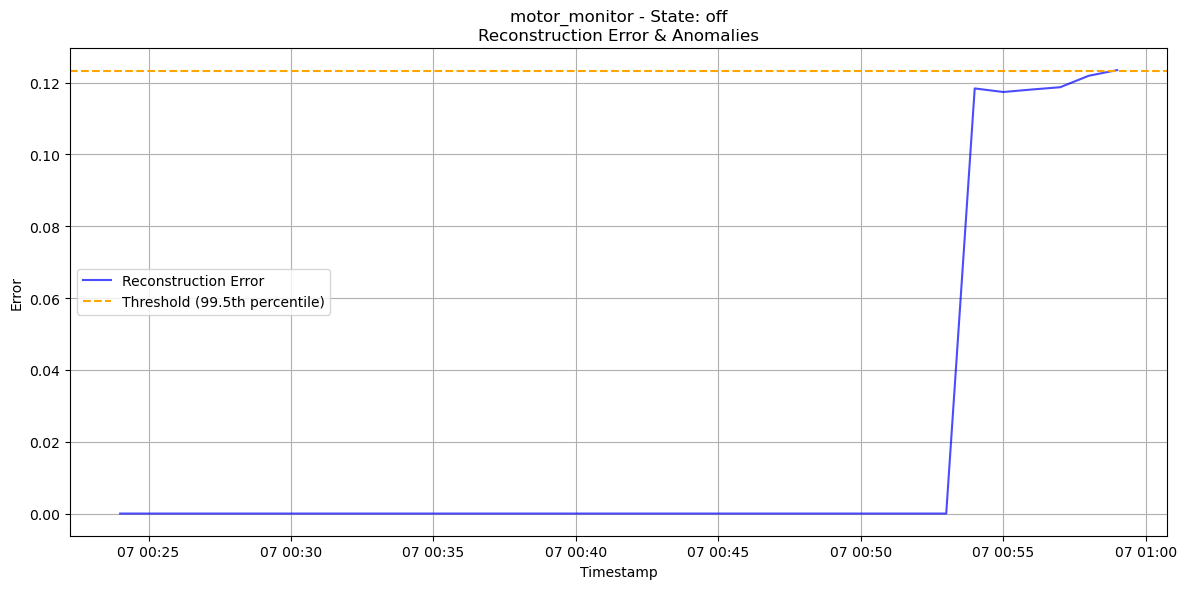

❌ Error processing motor_monitor: cannot access local variable 'batch_outputs' where it is not associated with a value
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:24:00   off  Normal       False  3.048236  2.457059   
1  2025-04-07 00:25:00   off  Normal       False  2.481396  2.919085   
2  2025-04-07 00:26:00   off  Normal       False  2.613110  2.735317   
3  2025-04-07 00:27:00   off  Normal       False  2.415534  2.813989   
4  2025-04-07 00:28:00   off  Normal       False  2.414530  2.569097   
5  2025-04-07 00:29:00   off  Normal       False  2.730771  2.327055   
6  2025-04-07 00:30:00   off  Normal       False  2.837282  2.524602   
7  2025-04-07 00:31:00   off  Normal       False  2.649856  2.755493   
8  2025-04-07 00:32:00   off  Normal       False  2.633452  2.905707   
9  2025-04-07 00:33:00   off  Normal       False  2.721608  2.737874   
10 2025-04-07 00:34:00   off  Normal       False  2.297623  2.171362 

g:\Conda\envs\python3.12\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Processing MQTT data for device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']
Threshold for g:\ABMT\anomaly-detection\src\pipeline\../../storage/saved_models/lstm_off.h5: 0.123708 (99.5th percentile)


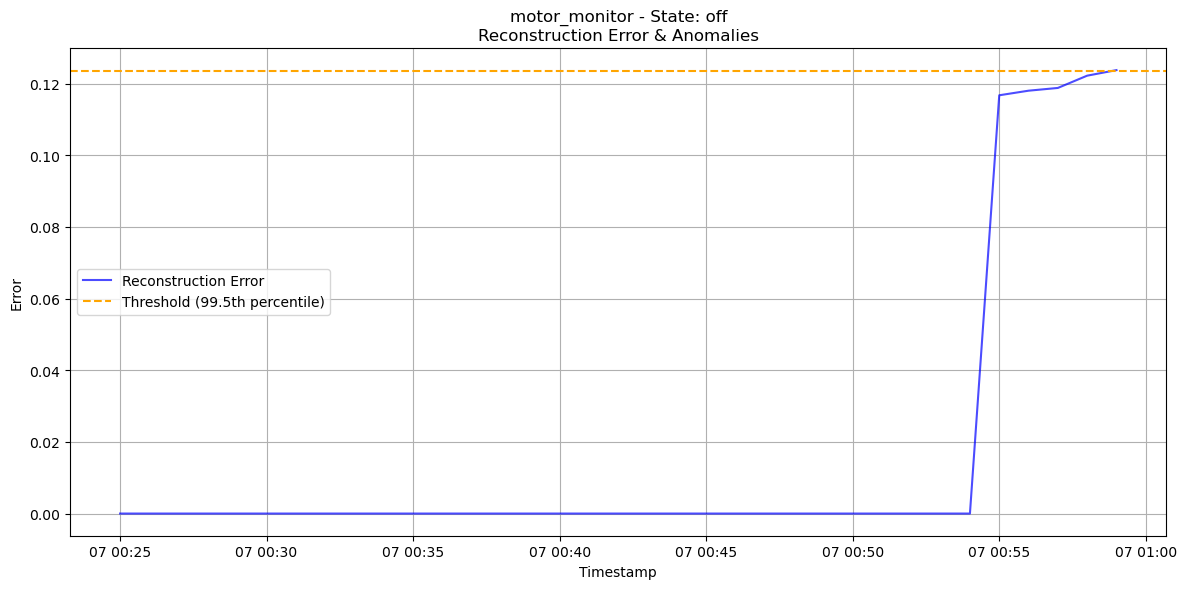

❌ Error processing motor_monitor: cannot access local variable 'batch_outputs' where it is not associated with a value
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:25:00   off  Normal       False  2.481396  2.919085   
1  2025-04-07 00:26:00   off  Normal       False  2.613110  2.735317   
2  2025-04-07 00:27:00   off  Normal       False  2.415534  2.813989   
3  2025-04-07 00:28:00   off  Normal       False  2.414530  2.569097   
4  2025-04-07 00:29:00   off  Normal       False  2.730771  2.327055   
5  2025-04-07 00:30:00   off  Normal       False  2.837282  2.524602   
6  2025-04-07 00:31:00   off  Normal       False  2.649856  2.755493   
7  2025-04-07 00:32:00   off  Normal       False  2.633452  2.905707   
8  2025-04-07 00:33:00   off  Normal       False  2.721608  2.737874   
9  2025-04-07 00:34:00   off  Normal       False  2.297623  2.171362   
10 2025-04-07 00:35:00   off  Normal       False  2.969725  2.698484 

g:\Conda\envs\python3.12\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Processing MQTT data for device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']
Threshold for g:\ABMT\anomaly-detection\src\pipeline\../../storage/saved_models/lstm_off.h5: 0.124295 (99.5th percentile)


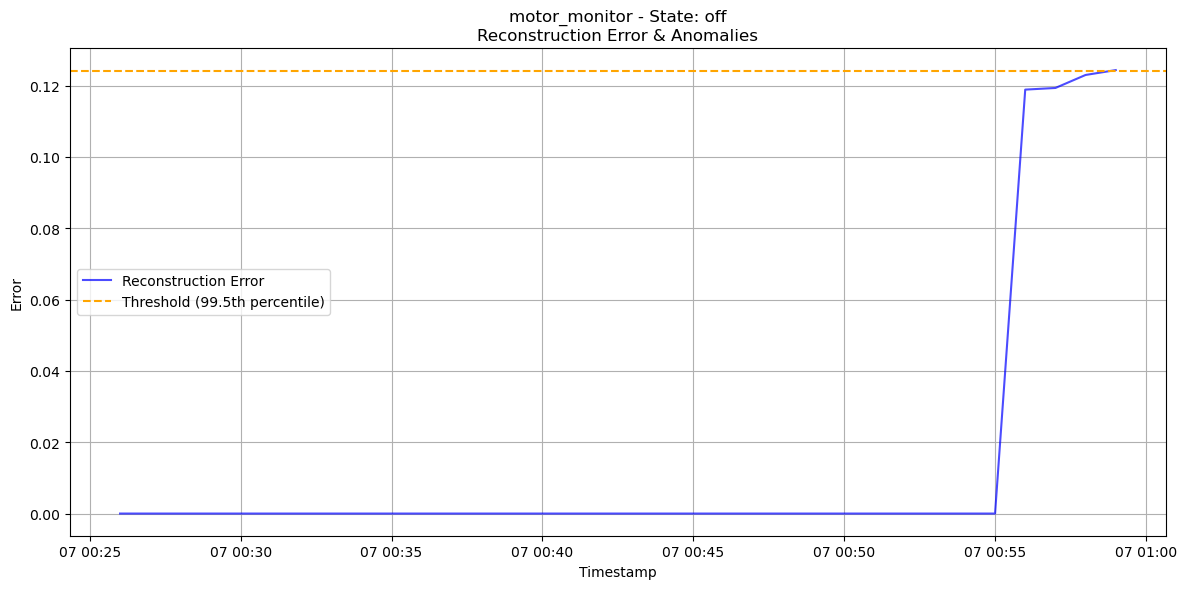

❌ Error processing motor_monitor: cannot access local variable 'batch_outputs' where it is not associated with a value
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:26:00   off  Normal       False  2.613110  2.735317   
1  2025-04-07 00:27:00   off  Normal       False  2.415534  2.813989   
2  2025-04-07 00:28:00   off  Normal       False  2.414530  2.569097   
3  2025-04-07 00:29:00   off  Normal       False  2.730771  2.327055   
4  2025-04-07 00:30:00   off  Normal       False  2.837282  2.524602   
5  2025-04-07 00:31:00   off  Normal       False  2.649856  2.755493   
6  2025-04-07 00:32:00   off  Normal       False  2.633452  2.905707   
7  2025-04-07 00:33:00   off  Normal       False  2.721608  2.737874   
8  2025-04-07 00:34:00   off  Normal       False  2.297623  2.171362   
9  2025-04-07 00:35:00   off  Normal       False  2.969725  2.698484   
10 2025-04-07 00:36:00   off  Normal       False  3.258949  2.721850 

g:\Conda\envs\python3.12\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Processing MQTT data for device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']
Threshold for g:\ABMT\anomaly-detection\src\pipeline\../../storage/saved_models/lstm_off.h5: 0.125073 (99.5th percentile)


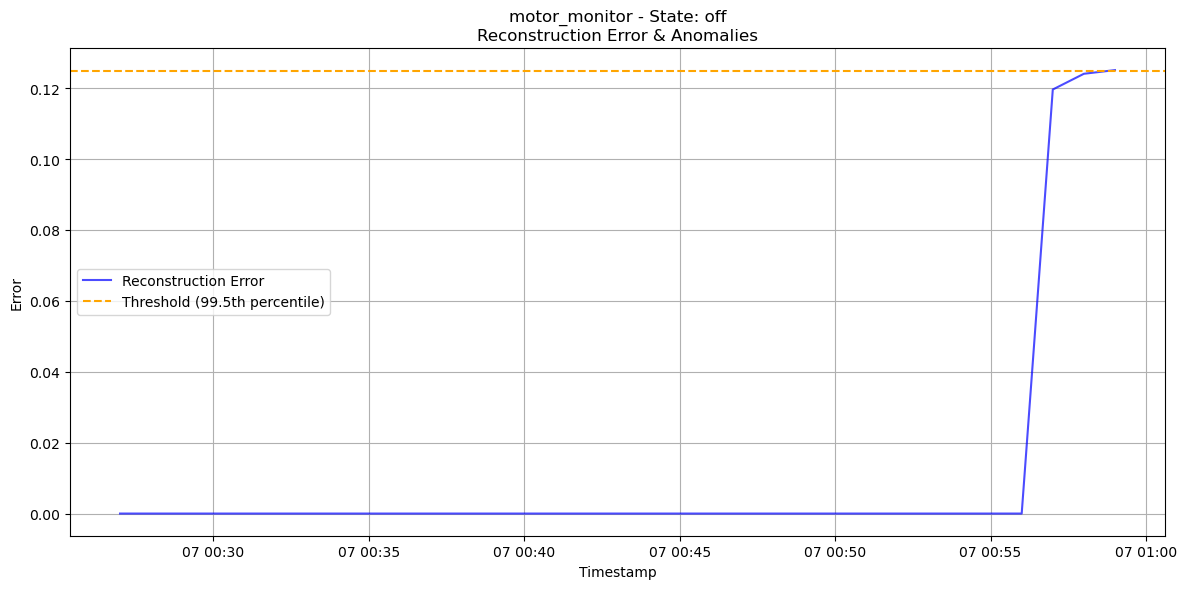

❌ Error processing motor_monitor: cannot access local variable 'batch_outputs' where it is not associated with a value
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:27:00   off  Normal       False  2.415534  2.813989   
1  2025-04-07 00:28:00   off  Normal       False  2.414530  2.569097   
2  2025-04-07 00:29:00   off  Normal       False  2.730771  2.327055   
3  2025-04-07 00:30:00   off  Normal       False  2.837282  2.524602   
4  2025-04-07 00:31:00   off  Normal       False  2.649856  2.755493   
5  2025-04-07 00:32:00   off  Normal       False  2.633452  2.905707   
6  2025-04-07 00:33:00   off  Normal       False  2.721608  2.737874   
7  2025-04-07 00:34:00   off  Normal       False  2.297623  2.171362   
8  2025-04-07 00:35:00   off  Normal       False  2.969725  2.698484   
9  2025-04-07 00:36:00   off  Normal       False  3.258949  2.721850   
10 2025-04-07 00:37:00   off  Normal       False  2.974927  2.295401 

g:\Conda\envs\python3.12\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Processing MQTT data for device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']
Threshold for g:\ABMT\anomaly-detection\src\pipeline\../../storage/saved_models/lstm_off.h5: 0.127004 (99.5th percentile)


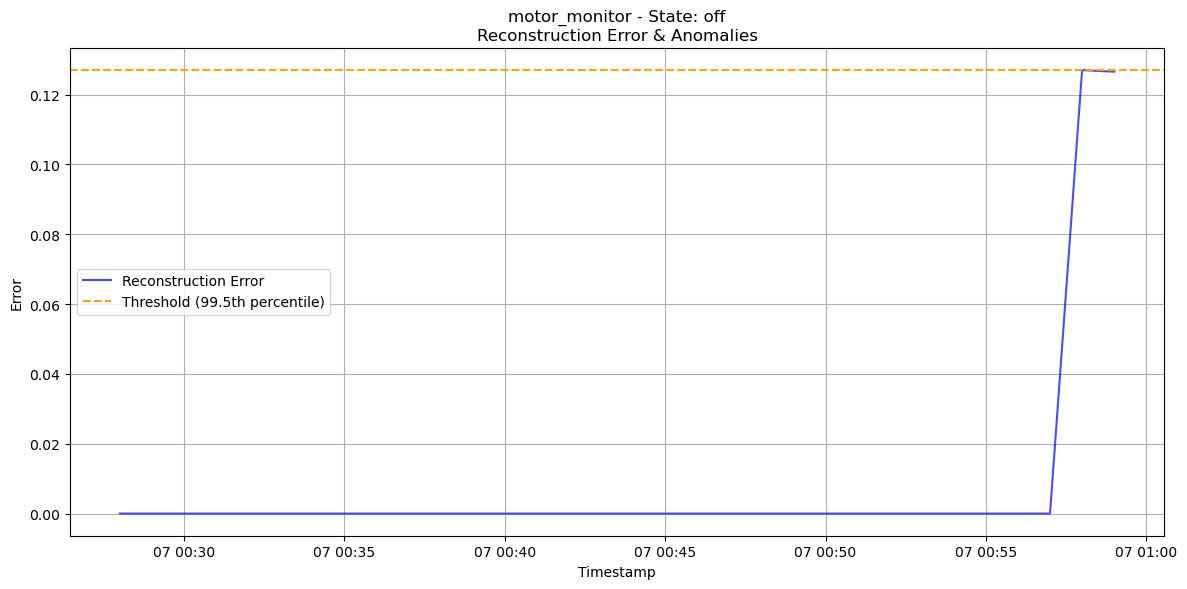

❌ Error processing motor_monitor: cannot access local variable 'batch_outputs' where it is not associated with a value
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:28:00   off  Normal       False  2.414530  2.569097   
1  2025-04-07 00:29:00   off  Normal       False  2.730771  2.327055   
2  2025-04-07 00:30:00   off  Normal       False  2.837282  2.524602   
3  2025-04-07 00:31:00   off  Normal       False  2.649856  2.755493   
4  2025-04-07 00:32:00   off  Normal       False  2.633452  2.905707   
5  2025-04-07 00:33:00   off  Normal       False  2.721608  2.737874   
6  2025-04-07 00:34:00   off  Normal       False  2.297623  2.171362   
7  2025-04-07 00:35:00   off  Normal       False  2.969725  2.698484   
8  2025-04-07 00:36:00   off  Normal       False  3.258949  2.721850   
9  2025-04-07 00:37:00   off  Normal       False  2.974927  2.295401   
10 2025-04-07 00:38:00   off  Normal       False  2.304582  2.969390 

g:\Conda\envs\python3.12\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Processing MQTT data for device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']
Threshold for g:\ABMT\anomaly-detection\src\pipeline\../../storage/saved_models/lstm_off.h5: 0.126231 (99.5th percentile)


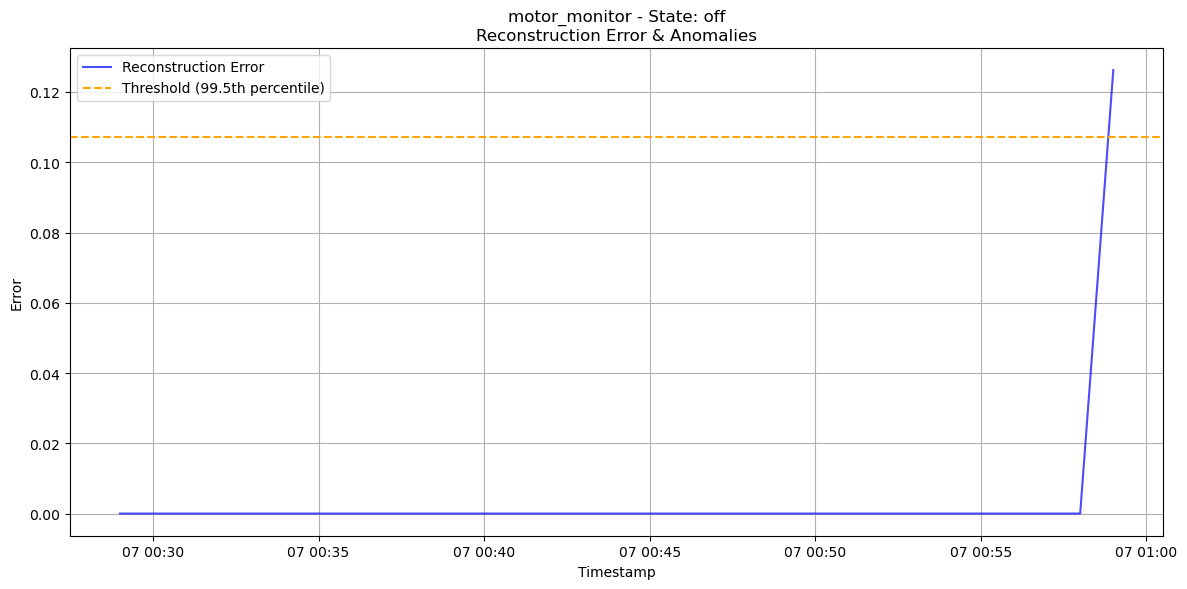

g:\Conda\envs\python3.12\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
g:\Conda\envs\python3.12\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


❌ Error processing motor_monitor: cannot access local variable 'batch_outputs' where it is not associated with a value
✅ Inference result:
             timestamp state   label  is_anomaly     power       rpm  \
0  2025-04-07 00:29:00   off  Normal       False  2.730771  2.327055   
1  2025-04-07 00:30:00   off  Normal       False  2.837282  2.524602   
2  2025-04-07 00:31:00   off  Normal       False  2.649856  2.755493   
3  2025-04-07 00:32:00   off  Normal       False  2.633452  2.905707   
4  2025-04-07 00:33:00   off  Normal       False  2.721608  2.737874   
5  2025-04-07 00:34:00   off  Normal       False  2.297623  2.171362   
6  2025-04-07 00:35:00   off  Normal       False  2.969725  2.698484   
7  2025-04-07 00:36:00   off  Normal       False  3.258949  2.721850   
8  2025-04-07 00:37:00   off  Normal       False  2.974927  2.295401   
9  2025-04-07 00:38:00   off  Normal       False  2.304582  2.969390   
10 2025-04-07 00:39:00   off  Normal       False  2.474997  2.648972 

g:\Conda\envs\python3.12\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Processing MQTT data for device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']
❌ Error processing motor_monitor: cannot access local variable 'batch_outputs' where it is not associated with a value
✅ Inference result:
Empty DataFrame
Columns: []
Index: []
length of last_30_rows: 40


g:\Conda\envs\python3.12\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Processing MQTT data for device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']
❌ Error processing motor_monitor: cannot access local variable 'batch_outputs' where it is not associated with a value
✅ Inference result:
Empty DataFrame
Columns: []
Index: []
length of last_30_rows: 40


g:\Conda\envs\python3.12\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Processing MQTT data for device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']
❌ Error processing motor_monitor: cannot access local variable 'batch_outputs' where it is not associated with a value
✅ Inference result:
Empty DataFrame
Columns: []
Index: []
length of last_30_rows: 40


g:\Conda\envs\python3.12\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Processing MQTT data for device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']
❌ Error processing motor_monitor: cannot access local variable 'batch_outputs' where it is not associated with a value
✅ Inference result:
Empty DataFrame
Columns: []
Index: []
length of last_30_rows: 40


g:\Conda\envs\python3.12\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Processing MQTT data for device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']
❌ Error processing motor_monitor: cannot access local variable 'batch_outputs' where it is not associated with a value
✅ Inference result:
Empty DataFrame
Columns: []
Index: []
length of last_30_rows: 40


g:\Conda\envs\python3.12\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Processing MQTT data for device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']
❌ Error processing motor_monitor: cannot access local variable 'batch_outputs' where it is not associated with a value
✅ Inference result:
Empty DataFrame
Columns: []
Index: []
length of last_30_rows: 40


g:\Conda\envs\python3.12\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


🛑 MQTT client stopped.


In [23]:
# Create MQTT client instance
# Required sensor features for a complete row
REQUIRED_FEATURES = {"power", "rpm", "temperature", "vibration"}

# Temporary buffer: timestamp (str) -> partial row (dict)
aggregated_rows = defaultdict(dict)

# Rolling history of last 30 complete rows (as DataFrames)
last_30_rows = deque(maxlen=40)

def handle_mqtt_message(topic, payload, on_complete_row=None):
    """
    Aggregates MQTT messages into complete rows by timestamp.
    When a full set of features is collected, creates a one-row DataFrame,
    calls `on_complete_row(df)`, and saves it to `last_30_rows`.

    Args:
        topic (str): Full MQTT topic string.
        payload (dict): Decoded JSON payload with fields like 'value', 'timestamp', etc.
        on_complete_row (function): Optional callback that receives the one-row DataFrame.
    """
    if (topic.split("/")[-2].lower()) != "motor4":
        return
    feature = topic.split("/")[-1].lower()
    timestamp = payload["timestamp"]

    row = aggregated_rows[timestamp]
    row["timestamp"] = timestamp
    row["state"] = payload["state"]
    row["label"] = payload["label"]
    row["is_anomaly"] = payload["is_anomaly"]
    row[feature] = payload["value"]


    # Check if all required features are present
    if REQUIRED_FEATURES.issubset(row):
        # Create one-row DataFrame
        row_df = pd.DataFrame([row])
        row_df["timestamp"] = pd.to_datetime(row_df["timestamp"])

        # Call the callback if provided
        if on_complete_row and len(last_30_rows) >= 30:
            on_complete_row(last_30_rows)

        # Save to rolling buffer
        last_30_rows.append(row_df)
        print(f"length of last_30_rows: {len(last_30_rows)}")

        # Clear this timestamp's entry
        del aggregated_rows[timestamp]

def on_complete_row(df_row):

    # Example: Run anomaly detection or classification
    result = process_device_mqtt("motor_monitor", last_30_rows)

    # Save result, update dashboard, send alert, etc.
    print(f"✅ Inference result:\n{result}")

def custom_handle_msg(topic, payload):
    handle_mqtt_message(topic, payload, on_complete_row=on_complete_row)

client = mqtt_receiver.start_mqtt_receiver(on_msg_callback=custom_handle_msg)

# Main loop just to demonstrate
try:
    while True:
        time.sleep(5)
except KeyboardInterrupt:
    client.loop_stop()
    client.disconnect()
    print("🛑 MQTT client stopped.")


In [ ]:
client.loop_stop()
client.disconnect()

In [ ]:
device_files = get_device_files()
all_results = {}

for device_type, csv_file in device_files:
    result = process_device_offline(device_type, csv_file)
    if result is not None:
        all_results[device_type] = result

for device_name, df_result in all_results.items():
    train_rf_for_device(device_name, df_result)
import time
global_end_time = time.time()

end_memory = process.memory_info().rss / (1024 * 1024)

print("\n✅ ALL DEVICES PROCESSED")
print(f"⏱️ Total Time: {global_end_time - global_start_time:.2f} sec")
print(f"💾 Start Memory: {start_memory:.2f} MB")
print(f"💾 End Memory: {end_memory:.2f} MB")
print(f"📈 Memory Growth: {end_memory - start_memory:.2f} MB")